In [312]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from skimage import filters, morphology, measure, color
import aicsimageio as aics

import glob

plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['font.size'] = 20
plt.style.use('seaborn-v0_8-ticks')

In [313]:
color_palette = {'DMSO' : '#4d4d4d',
                 'ARYL_AG':'#F8766D', 'ARYL_INH':'#F8766D50',
                 'ANDR_AG':'#fccb17', 'ANDR_INH':'#C49A0050',  
                 "ESTR_AG": '#53B400', "ESTR_INH": '#53B40050', 
                 'GC_AG' : '#00C094', 'GC_INH' : '#00C09450',
                 'LX_AG' : '#00B6EB', 'LX_INH' : '#00B6EB50', 
                 'RET_AG' : '#A58AFF', 'RET_INH' : '#A58AFF50', 
                 'THYR_AG' : '#FB61D7', 'THYR_INH' : '#FB61D750'
}

line_palette = {
    'CTL08A': "#99cfd670",  
    'CTL04E': "#f8c88a70",  
}

In [314]:
color_palette_expanded = {'DMSO_CTL08A': '#cacaca',
 'DMSO_CTL04E': '#4d4d4d',
 'ARYL_AG_CTL08A': '#fdd6d3',
 'ARYL_AG_CTL04E': '#F8766D',
 'ARYL_INH_CTL08A': '#fdd6d3',
 'ARYL_INH_CTL04E': '#F8766D50',
 'ANDR_AG_CTL08A': '#feefb9',
 'ANDR_AG_CTL04E': '#fccb17',
 'ANDR_INH_CTL08A': '#ede1b250',
 'ANDR_INH_CTL04E': '#C49A0050',
 'ESTR_AG_CTL08A': '#cbe8b2',
 'ESTR_AG_CTL04E': '#53B400',
 'ESTR_INH_CTL08A': '#cbe8b250',
 'ESTR_INH_CTL04E': '#53B40050',
 'GC_AG_CTL08A': '#b2ecdf',
 'GC_AG_CTL04E': '#00C094',
 'GC_INH_CTL08A': '#b2ecdf50',
 'GC_INH_CTL04E': '#00C09450',
 'LX_AG_CTL08A': '#b2e9f9',
 'LX_AG_CTL04E': '#00B6EB',
 'LX_INH_CTL08A': '#b2e9f950',
 'LX_INH_CTL04E': '#00B6EB50',
 'RET_AG_CTL08A': '#e4dcff',
 'RET_AG_CTL04E': '#A58AFF',
 'RET_INH_CTL08A': '#e4dcff50',
 'RET_INH_CTL04E': '#A58AFF50',
 'THYR_AG_CTL08A': '#fed0f3',
 'THYR_AG_CTL04E': '#FB61D7',
 'THYR_INH_CTL08A': '#fed0f350',
 'THYR_INH_CTL04E': '#FB61D750'}


In [315]:
hormonal_conditions = ['ESTR_AG', 'ESTR_INH', 'ANDR_AG', 'ANDR_INH', 'ARYL_INH',
       'ARYL_AG', 'LX_AG', 'GC_AG', 'LX_INH', 'GC_INH', 'THYR_INH',
       'THYR_AG', 'DMSO', 'RET_AG',
       'RET_INH']
hormonal_conditions.remove('DMSO')
hormonal_conditions.sort()
hormonal_conditions = ['DMSO'] + hormonal_conditions

# Load manual checks

In [316]:
blank_mix1 = glob.glob('/group/testa/Project/EndPoints/TPSSU/analysis/single_tif_scanregion/*0136*.tif')
blank_mix1 = [f.split('/')[-1].split('.')[0] for f in blank_mix1]
blank_mix2 = glob.glob('/group/testa/Project/EndPoints/TPSSU/analysis/single_tif_scanregion/*0145*.tif')
blank_mix2 = [f.split('/')[-1].split('.')[0] for f in blank_mix2]

In [317]:
check_qc_ch1 = pd.read_csv('../../preprocessing/tables/Treshold_QC_check - Channel1_no_dup.csv')
check_qc_ch2 = pd.read_csv('../../preprocessing/tables/Treshold_QC_check - Channel2_no_dup.csv')

In [318]:
check_qc_ch1['general QC (keep or not)'] = check_qc_ch1['general QC (keep or not)'].str.upper()
check_qc_ch1['general QC (keep or not)'] = check_qc_ch1['general QC (keep or not)'].replace({'BETTER NOT': 'LIMIT', 'MAYBE': 'LIMIT', 'YES?': 'LIMIT', 'SUS': 'LIMIT', 'NOT SURE': 'LIMIT', 'YES ': 'YES', 'YES - 2 CBO': 'YES'})
check_qc_ch1['general QC (keep or not)'].value_counts().index

Index(['YES', 'LIMIT', 'NO'], dtype='object', name='general QC (keep or not)')

In [319]:
check_qc_ch1['Reference Image Report'] = check_qc_ch1['Reference Image Report'].str.replace('.pdf', '')

In [320]:
check_qc_ch1['Reference Image Report'].value_counts()

Reference Image Report
20240424_manuel_lessi_0148_ScanRegion1_rep_1_channel_1    1
20240424_manuel_lessi_0145_ScanRegion2_rep_2_channel_1    1
20240424_manuel_lessi_0145_ScanRegion3_rep_0_channel_1    1
20240424_manuel_lessi_0145_ScanRegion3_rep_1_channel_1    1
20240424_manuel_lessi_0145_ScanRegion3_rep_2_channel_1    1
                                                         ..
20240424_manuel_lessi_0136_ScanRegion2_rep_1_channel_1    1
20240424_manuel_lessi_0136_ScanRegion2_rep_2_channel_1    1
20240424_manuel_lessi_0136_ScanRegion3_rep_0_channel_1    1
20240424_manuel_lessi_0136_ScanRegion3_rep_1_channel_1    1
20240424_manuel_lessi_0136_ScanRegion3_rep_2_channel_1    1
Name: count, Length: 153, dtype: int64

In [321]:
check_qc_ch2['general QC (keep or not)'] = check_qc_ch2['general QC (keep or not)'].str.upper()
check_qc_ch2['general QC (keep or not)'] = check_qc_ch2['general QC (keep or not)'].replace({'NOT SURE': 'LIMIT', '?': 'LIMIT', 'YES ': 'YES'})
check_qc_ch2['general QC (keep or not)'].value_counts().index

Index(['YES', 'NO', 'LIMIT'], dtype='object', name='general QC (keep or not)')

In [322]:
check_qc_ch2['Reference Image Report'] = check_qc_ch2['Reference Image Report'].str.replace('.pdf', '')

In [323]:
check_qc_ch1['Reference Image Report'].value_counts()

Reference Image Report
20240424_manuel_lessi_0148_ScanRegion1_rep_1_channel_1    1
20240424_manuel_lessi_0145_ScanRegion2_rep_2_channel_1    1
20240424_manuel_lessi_0145_ScanRegion3_rep_0_channel_1    1
20240424_manuel_lessi_0145_ScanRegion3_rep_1_channel_1    1
20240424_manuel_lessi_0145_ScanRegion3_rep_2_channel_1    1
                                                         ..
20240424_manuel_lessi_0136_ScanRegion2_rep_1_channel_1    1
20240424_manuel_lessi_0136_ScanRegion2_rep_2_channel_1    1
20240424_manuel_lessi_0136_ScanRegion3_rep_0_channel_1    1
20240424_manuel_lessi_0136_ScanRegion3_rep_1_channel_1    1
20240424_manuel_lessi_0136_ScanRegion3_rep_2_channel_1    1
Name: count, Length: 153, dtype: int64

In [324]:
check_qc_ch1['ImageName_ScanRegion_Rep'] = check_qc_ch1['Reference Image Report'].apply(lambda x: '_'.join(x.split('_')[:7]))
check_qc_ch2['ImageName_ScanRegion_Rep'] = check_qc_ch2['Reference Image Report'].apply(lambda x: '_'.join(x.split('_')[:7]))

to_keep_ch1 = check_qc_ch1[check_qc_ch1['general QC (keep or not)'].isin(['YES', 'LIMIT'])]
to_keep_ch2 = check_qc_ch2[check_qc_ch2['general QC (keep or not)'].isin(['YES', 'LIMIT'])]

len(set(to_keep_ch1['ImageName_ScanRegion_Rep']).intersection(set(to_keep_ch2['ImageName_ScanRegion_Rep'])))

100

In [325]:
len(check_qc_ch1['ImageName_ScanRegion_Rep'])

153

In [326]:
len(check_qc_ch2['ImageName_ScanRegion_Rep'])

275

In [327]:
good_tissue_to_keep_limit = list(set(check_qc_ch1[check_qc_ch1['general QC (keep or not)'].isin(['YES', 'LIMIT'])]['ImageName_ScanRegion_Rep']).union(set(check_qc_ch2[check_qc_ch2['general QC (keep or not)'].isin(['YES', 'LIMIT'])]['ImageName_ScanRegion_Rep'])))

In [328]:
len(good_tissue_to_keep_limit)

245

In [329]:
good_tissue_to_keep_limit_df = pd.DataFrame(good_tissue_to_keep_limit, columns=['ImageName_ScanRegion_Rep'])

In [330]:
good_tissue_to_keep_limit_df['ImageName_ScanRegion'] = good_tissue_to_keep_limit_df['ImageName_ScanRegion_Rep'].apply(lambda x: '_'.join(x.split('_')[:5]))
good_tissue_to_keep_limit_df

,ImageName_ScanRegion_Rep,ImageName_ScanRegion
0,20240424_manuel_lessi_0129_ScanRegion2_rep_0,20240424_manuel_lessi_0129_ScanRegion2
1,20240424_manuel_lessi_0141_ScanRegion0_rep_1,20240424_manuel_lessi_0141_ScanRegion0
2,20240424_manuel_lessi_0138_ScanRegion0_rep_1,20240424_manuel_lessi_0138_ScanRegion0
3,20240424_manuel_lessi_0145_ScanRegion3_rep_2,20240424_manuel_lessi_0145_ScanRegion3
4,20240424_manuel_lessi_0141_ScanRegion0_rep_0,20240424_manuel_lessi_0141_ScanRegion0
...,...,...
240,20240424_manuel_lessi_0147_ScanRegion1_rep_2,20240424_manuel_lessi_0147_ScanRegion1
241,20240424_manuel_lessi_0130_ScanRegion2_rep_2,20240424_manuel_lessi_0130_ScanRegion2
242,20240424_manuel_lessi_0130_ScanRegion1_rep_1,20240424_manuel_lessi_0130_ScanRegion1
243,20240424_manuel_lessi_0143_ScanRegion2_rep_0,20240424_manuel_lessi_0143_ScanRegion2


# Load sample sheet

In [331]:
sample_sheet  = pd.read_csv('../../preprocessing/tables/endpoints_ImageAnalysisSampleSheet.csv')

In [332]:
sample_sheet = sample_sheet[sample_sheet['Condition'].isin(hormonal_conditions)]

In [333]:
sample_sheet['Condition'] = sample_sheet['Condition'].str.replace('_ANT', '_INH')

In [334]:
sample_sheet['Condition'].unique()

array(['ESTR_AG', 'ESTR_INH', 'ANDR_AG', 'ARYL_INH', 'ARYL_AG', 'LX_AG',
       'GC_AG', 'LX_INH', 'GC_INH', 'THYR_INH', 'THYR_AG', 'DMSO',
       'RET_AG', 'RET_INH', 'ANDR_INH'], dtype=object)

In [335]:

sample_sheet['ImageName'] = sample_sheet['Path'].apply(lambda x: x.split('\\')[-1].split('.')[0])
sample_sheet['ImageName_ScanRegion'] = sample_sheet['ImageName'] + '_' + sample_sheet['Scan Area']
sample_sheet['Condition_Line'] = sample_sheet['Condition'] + '_' + sample_sheet['Line ']
sample_sheet

,Path,Scan Area,Condition,Line,OPA,Paraffin Block ID,MIX,ImageName,ImageName_ScanRegion,Condition_Line
0,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion0,ESTR_AG,CTL04E,12,29,1,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion0,ESTR_AG_CTL04E
1,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion1,ESTR_AG,CTL08A,12,30,1,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion1,ESTR_AG_CTL08A
2,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion2,ESTR_INH,CTL04E,12,31,1,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion2,ESTR_INH_CTL04E
3,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion3,ANDR_AG,CTL04E,12,33,1,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion3,ANDR_AG_CTL04E
4,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion4,ESTR_INH,CTL08A,12,32,1,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion4,ESTR_INH_CTL08A
5,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion5,ANDR_AG,CTL08A,12,34,1,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion5,ANDR_AG_CTL08A
7,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion1,ARYL_INH,CTL08A,13,40,1,20240424_manuel_lessi_0129,20240424_manuel_lessi_0129_ScanRegion1,ARYL_INH_CTL08A
8,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion2,ARYL_INH,CTL04E,13,39,1,20240424_manuel_lessi_0129,20240424_manuel_lessi_0129_ScanRegion2,ARYL_INH_CTL04E
9,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion3,ARYL_AG,CTL08A,13,38,1,20240424_manuel_lessi_0129,20240424_manuel_lessi_0129_ScanRegion3,ARYL_AG_CTL08A
11,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion5,ARYL_AG,CTL04E,13,37,1,20240424_manuel_lessi_0129,20240424_manuel_lessi_0129_ScanRegion5,ARYL_AG_CTL04E


In [336]:
sample_dict= {i:j for i, j in zip(sample_sheet['ImageName_ScanRegion'], sample_sheet['Condition_Line'])}

In [337]:
mix_1_names = sample_sheet[sample_sheet['MIX'] == 1]['ImageName'].tolist()
mix_2_names = sample_sheet[sample_sheet['MIX'] == 2]['ImageName'].tolist()

In [338]:
sample_sheet['Condition'].unique()

array(['ESTR_AG', 'ESTR_INH', 'ANDR_AG', 'ARYL_INH', 'ARYL_AG', 'LX_AG',
       'GC_AG', 'LX_INH', 'GC_INH', 'THYR_INH', 'THYR_AG', 'DMSO',
       'RET_AG', 'RET_INH', 'ANDR_INH'], dtype=object)

# Load measurements file names

In [339]:
measurements_files = glob.glob("/group/testa/Project/EndPoints/TPSSU/analysis/measurements/*.csv")
measurements_files_mix_1 = [f for f in measurements_files if any(name in f for name in mix_1_names)]
measurements_files_mix_2 = [f for f in measurements_files if any(name in f for name in mix_2_names)]

In [340]:
mask_file = pd.read_csv("/group/testa/Project/EndPoints/TPSSU/analysis/cytoplasmatic_measures/cyto_mask_measures.csv", index_col=0)
mask_file

,level_0,level_1,area,label,intensity_mean,intensity_min,intensity_max
0,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0134_ScanRegion0_rep_0_c...,41353242.0,1,2417.670006,1451.0,24120.0
1,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0134_ScanRegion0_rep_1_c...,16657221.0,1,3091.305189,1683.0,18027.0
2,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0134_ScanRegion0_rep_2_c...,44113333.0,1,3377.073590,1493.0,27952.0
3,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0134_ScanRegion1_rep_0_c...,10098868.0,1,2645.539375,1110.0,27468.0
4,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0134_ScanRegion1_rep_1_c...,7030992.0,1,3937.014572,1941.0,25144.0
...,...,...,...,...,...,...,...
275,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0144_ScanRegion2_rep_1_c...,23124873.0,1,4259.092122,2134.0,44177.0
276,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0144_ScanRegion2_rep_2_c...,3373772.0,1,5777.220379,2861.0,33473.0
277,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0144_ScanRegion3_rep_0_c...,10606818.0,1,6209.021854,3028.0,52453.0
278,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0144_ScanRegion3_rep_1_c...,27412715.0,1,3358.864704,1478.0,28030.0


In [341]:
mask_file['OriginalImageName'] = mask_file['level_1'].apply(lambda x: '_'.join(x.split('_')[0:4]))
mask_file['ImageName_ScanRegion'] = mask_file['level_1'].apply(lambda x: '_'.join(x.split('_')[0:5]))
mask_file['ImageName_ScanRegion_Rep'] = mask_file['level_1'].apply(lambda x: '_'.join(x.split('_')[0:7]))
mask_file

,level_0,level_1,area,label,intensity_mean,intensity_min,intensity_max,OriginalImageName,ImageName_ScanRegion,ImageName_ScanRegion_Rep
0,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0134_ScanRegion0_rep_0_c...,41353242.0,1,2417.670006,1451.0,24120.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion0,20240424_manuel_lessi_0134_ScanRegion0_rep_0
1,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0134_ScanRegion0_rep_1_c...,16657221.0,1,3091.305189,1683.0,18027.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion0,20240424_manuel_lessi_0134_ScanRegion0_rep_1
2,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0134_ScanRegion0_rep_2_c...,44113333.0,1,3377.073590,1493.0,27952.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion0,20240424_manuel_lessi_0134_ScanRegion0_rep_2
3,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0134_ScanRegion1_rep_0_c...,10098868.0,1,2645.539375,1110.0,27468.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion1,20240424_manuel_lessi_0134_ScanRegion1_rep_0
4,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0134_ScanRegion1_rep_1_c...,7030992.0,1,3937.014572,1941.0,25144.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion1,20240424_manuel_lessi_0134_ScanRegion1_rep_1
...,...,...,...,...,...,...,...,...,...,...
275,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0144_ScanRegion2_rep_1_c...,23124873.0,1,4259.092122,2134.0,44177.0,20240424_manuel_lessi_0144,20240424_manuel_lessi_0144_ScanRegion2,20240424_manuel_lessi_0144_ScanRegion2_rep_1
276,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0144_ScanRegion2_rep_2_c...,3373772.0,1,5777.220379,2861.0,33473.0,20240424_manuel_lessi_0144,20240424_manuel_lessi_0144_ScanRegion2,20240424_manuel_lessi_0144_ScanRegion2_rep_2
277,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0144_ScanRegion3_rep_0_c...,10606818.0,1,6209.021854,3028.0,52453.0,20240424_manuel_lessi_0144,20240424_manuel_lessi_0144_ScanRegion3,20240424_manuel_lessi_0144_ScanRegion3_rep_0
278,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0144_ScanRegion3_rep_1_c...,27412715.0,1,3358.864704,1478.0,28030.0,20240424_manuel_lessi_0144,20240424_manuel_lessi_0144_ScanRegion3,20240424_manuel_lessi_0144_ScanRegion3_rep_1


In [342]:
mask_file_df_mix_1 = mask_file[mask_file.OriginalImageName.isin(mix_1_names)]
mask_file_df_mix_1

,level_0,level_1,area,label,intensity_mean,intensity_min,intensity_max,OriginalImageName,ImageName_ScanRegion,ImageName_ScanRegion_Rep
0,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0134_ScanRegion0_rep_0_c...,41353242.0,1,2417.670006,1451.0,24120.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion0,20240424_manuel_lessi_0134_ScanRegion0_rep_0
1,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0134_ScanRegion0_rep_1_c...,16657221.0,1,3091.305189,1683.0,18027.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion0,20240424_manuel_lessi_0134_ScanRegion0_rep_1
2,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0134_ScanRegion0_rep_2_c...,44113333.0,1,3377.073590,1493.0,27952.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion0,20240424_manuel_lessi_0134_ScanRegion0_rep_2
3,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0134_ScanRegion1_rep_0_c...,10098868.0,1,2645.539375,1110.0,27468.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion1,20240424_manuel_lessi_0134_ScanRegion1_rep_0
4,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0134_ScanRegion1_rep_1_c...,7030992.0,1,3937.014572,1941.0,25144.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion1,20240424_manuel_lessi_0134_ScanRegion1_rep_1
...,...,...,...,...,...,...,...,...,...,...
253,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0128_ScanRegion4_rep_0_c...,31563732.0,1,5826.471794,2338.0,65535.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion4,20240424_manuel_lessi_0128_ScanRegion4_rep_0
254,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0128_ScanRegion4_rep_1_c...,15937774.0,1,4450.546162,1907.0,34600.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion4,20240424_manuel_lessi_0128_ScanRegion4_rep_1
255,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0128_ScanRegion5_rep_0_c...,27625720.0,1,8458.966141,3148.0,65535.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion5,20240424_manuel_lessi_0128_ScanRegion5_rep_0
256,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0128_ScanRegion5_rep_1_c...,24213189.0,1,8076.440269,3291.0,64452.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion5,20240424_manuel_lessi_0128_ScanRegion5_rep_1


In [343]:
mask_file_df_mix_2 = mask_file[mask_file.OriginalImageName.isin(mix_2_names)]
mask_file_df_mix_2

,level_0,level_1,area,label,intensity_mean,intensity_min,intensity_max,OriginalImageName,ImageName_ScanRegion,ImageName_ScanRegion_Rep
63,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0138_ScanRegion0_rep_0_c...,25216880.0,1,2897.342427,1595.0,46841.0,20240424_manuel_lessi_0138,20240424_manuel_lessi_0138_ScanRegion0,20240424_manuel_lessi_0138_ScanRegion0_rep_0
64,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0138_ScanRegion0_rep_1_c...,783450.0,1,5758.093586,2353.0,28128.0,20240424_manuel_lessi_0138,20240424_manuel_lessi_0138_ScanRegion0,20240424_manuel_lessi_0138_ScanRegion0_rep_1
65,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0138_ScanRegion0_rep_2_c...,9406872.0,1,2427.271453,1434.0,22097.0,20240424_manuel_lessi_0138,20240424_manuel_lessi_0138_ScanRegion0,20240424_manuel_lessi_0138_ScanRegion0_rep_2
66,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0138_ScanRegion1_rep_0_c...,19764267.0,1,4312.851140,1931.0,46239.0,20240424_manuel_lessi_0138,20240424_manuel_lessi_0138_ScanRegion1,20240424_manuel_lessi_0138_ScanRegion1_rep_0
67,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0138_ScanRegion1_rep_1_c...,16905853.0,1,5440.278854,1960.0,53194.0,20240424_manuel_lessi_0138,20240424_manuel_lessi_0138_ScanRegion1,20240424_manuel_lessi_0138_ScanRegion1_rep_1
...,...,...,...,...,...,...,...,...,...,...
225,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0140_ScanRegion4_rep_1_c...,31837996.0,1,3904.760504,1749.0,59013.0,20240424_manuel_lessi_0140,20240424_manuel_lessi_0140_ScanRegion4,20240424_manuel_lessi_0140_ScanRegion4_rep_1
226,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0140_ScanRegion4_rep_2_c...,18872105.0,1,3218.488803,1461.0,31570.0,20240424_manuel_lessi_0140,20240424_manuel_lessi_0140_ScanRegion4,20240424_manuel_lessi_0140_ScanRegion4_rep_2
227,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0140_ScanRegion5_rep_0_c...,26246594.0,1,5094.892965,2251.0,65058.0,20240424_manuel_lessi_0140,20240424_manuel_lessi_0140_ScanRegion5,20240424_manuel_lessi_0140_ScanRegion5_rep_0
228,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0140_ScanRegion5_rep_1_c...,1893364.0,1,10712.595047,4554.0,42993.0,20240424_manuel_lessi_0140,20240424_manuel_lessi_0140_ScanRegion5,20240424_manuel_lessi_0140_ScanRegion5_rep_1


In [344]:
SOX2_KI67_mask_file = pd.read_csv("/group/testa/Project/EndPoints/TPSSU/analysis/SOX2_signal_mask_measures/SOX2_mask_measures.csv", index_col=0)
SOX2_KI67_mask_file

,level_0,level_1,area,label,intensity_mean,intensity_min,intensity_max
0,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0138_ScanRegion0_rep_0_c...,4101511.0,1,3193.621243,760.0,58222.0
1,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0138_ScanRegion0_rep_1_c...,364102.0,1,1737.696456,799.0,32870.0
2,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0138_ScanRegion0_rep_2_c...,1211261.0,1,2790.889845,666.0,55530.0
3,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0138_ScanRegion1_rep_0_c...,5725447.0,1,2689.380828,667.0,65535.0
4,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0138_ScanRegion1_rep_1_c...,3492983.0,1,2311.704404,652.0,65535.0
...,...,...,...,...,...,...,...
275,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0147_ScanRegion0_rep_0_c...,28772264.0,1,2396.070626,1210.0,46386.0
276,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0147_ScanRegion0_rep_1_c...,65092576.0,1,1752.924324,920.0,65535.0
277,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0147_ScanRegion1_rep_0_c...,22241252.0,1,2317.127770,873.0,63830.0
278,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0147_ScanRegion1_rep_1_c...,21330335.0,1,2837.997036,1092.0,65535.0


In [345]:
SOX2_KI67_mask_file['OriginalImageName'] = SOX2_KI67_mask_file['level_1'].apply(lambda x: '_'.join(x.split('_')[0:4]))
SOX2_KI67_mask_file['ImageName_ScanRegion'] = SOX2_KI67_mask_file['level_1'].apply(lambda x: '_'.join(x.split('_')[0:5]))
SOX2_KI67_mask_file['ImageName_ScanRegion_Rep'] = SOX2_KI67_mask_file['level_1'].apply(lambda x: '_'.join(x.split('_')[0:7]))
SOX2_KI67_mask_file

,level_0,level_1,area,label,intensity_mean,intensity_min,intensity_max,OriginalImageName,ImageName_ScanRegion,ImageName_ScanRegion_Rep
0,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0138_ScanRegion0_rep_0_c...,4101511.0,1,3193.621243,760.0,58222.0,20240424_manuel_lessi_0138,20240424_manuel_lessi_0138_ScanRegion0,20240424_manuel_lessi_0138_ScanRegion0_rep_0
1,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0138_ScanRegion0_rep_1_c...,364102.0,1,1737.696456,799.0,32870.0,20240424_manuel_lessi_0138,20240424_manuel_lessi_0138_ScanRegion0,20240424_manuel_lessi_0138_ScanRegion0_rep_1
2,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0138_ScanRegion0_rep_2_c...,1211261.0,1,2790.889845,666.0,55530.0,20240424_manuel_lessi_0138,20240424_manuel_lessi_0138_ScanRegion0,20240424_manuel_lessi_0138_ScanRegion0_rep_2
3,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0138_ScanRegion1_rep_0_c...,5725447.0,1,2689.380828,667.0,65535.0,20240424_manuel_lessi_0138,20240424_manuel_lessi_0138_ScanRegion1,20240424_manuel_lessi_0138_ScanRegion1_rep_0
4,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0138_ScanRegion1_rep_1_c...,3492983.0,1,2311.704404,652.0,65535.0,20240424_manuel_lessi_0138,20240424_manuel_lessi_0138_ScanRegion1,20240424_manuel_lessi_0138_ScanRegion1_rep_1
...,...,...,...,...,...,...,...,...,...,...
275,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0147_ScanRegion0_rep_0_c...,28772264.0,1,2396.070626,1210.0,46386.0,20240424_manuel_lessi_0147,20240424_manuel_lessi_0147_ScanRegion0,20240424_manuel_lessi_0147_ScanRegion0_rep_0
276,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0147_ScanRegion0_rep_1_c...,65092576.0,1,1752.924324,920.0,65535.0,20240424_manuel_lessi_0147,20240424_manuel_lessi_0147_ScanRegion0,20240424_manuel_lessi_0147_ScanRegion0_rep_1
277,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0147_ScanRegion1_rep_0_c...,22241252.0,1,2317.127770,873.0,63830.0,20240424_manuel_lessi_0147,20240424_manuel_lessi_0147_ScanRegion1,20240424_manuel_lessi_0147_ScanRegion1_rep_0
278,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0147_ScanRegion1_rep_1_c...,21330335.0,1,2837.997036,1092.0,65535.0,20240424_manuel_lessi_0147,20240424_manuel_lessi_0147_ScanRegion1,20240424_manuel_lessi_0147_ScanRegion1_rep_1


In [346]:
SOX2_KI67_mask_file_df_mix_1 = SOX2_KI67_mask_file[SOX2_KI67_mask_file.OriginalImageName.isin(mix_1_names)]
SOX2_KI67_mask_file_df_mix_1

,level_0,level_1,area,label,intensity_mean,intensity_min,intensity_max,OriginalImageName,ImageName_ScanRegion,ImageName_ScanRegion_Rep
19,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0133_ScanRegion0_rep_0_c...,21490093.0,1,3839.355973,1168.0,38274.0,20240424_manuel_lessi_0133,20240424_manuel_lessi_0133_ScanRegion0,20240424_manuel_lessi_0133_ScanRegion0_rep_0
20,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0133_ScanRegion0_rep_1_c...,14199055.0,1,4477.197476,1226.0,46860.0,20240424_manuel_lessi_0133,20240424_manuel_lessi_0133_ScanRegion0,20240424_manuel_lessi_0133_ScanRegion0_rep_1
21,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0133_ScanRegion0_rep_2_c...,15755642.0,1,3759.473544,1092.0,43784.0,20240424_manuel_lessi_0133,20240424_manuel_lessi_0133_ScanRegion0,20240424_manuel_lessi_0133_ScanRegion0_rep_2
22,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0133_ScanRegion1_rep_0_c...,1037489.0,1,2031.997964,957.0,21498.0,20240424_manuel_lessi_0133,20240424_manuel_lessi_0133_ScanRegion1,20240424_manuel_lessi_0133_ScanRegion1_rep_0
23,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0133_ScanRegion1_rep_1_c...,2023185.0,1,3780.785030,1512.0,38018.0,20240424_manuel_lessi_0133,20240424_manuel_lessi_0133_ScanRegion1,20240424_manuel_lessi_0133_ScanRegion1_rep_1
...,...,...,...,...,...,...,...,...,...,...
270,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0128_ScanRegion4_rep_0_c...,16244663.0,1,4090.208776,1313.0,48739.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion4,20240424_manuel_lessi_0128_ScanRegion4_rep_0
271,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0128_ScanRegion4_rep_1_c...,7057712.0,1,4113.493459,1235.0,42141.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion4,20240424_manuel_lessi_0128_ScanRegion4_rep_1
272,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0128_ScanRegion5_rep_0_c...,12963431.0,1,5394.798945,1568.0,44306.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion5,20240424_manuel_lessi_0128_ScanRegion5_rep_0
273,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0128_ScanRegion5_rep_1_c...,10831979.0,1,4610.981995,1604.0,40226.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion5,20240424_manuel_lessi_0128_ScanRegion5_rep_1


In [347]:
SOX2_KI67_mask_file_df_mix_2 = SOX2_KI67_mask_file[SOX2_KI67_mask_file.OriginalImageName.isin(mix_2_names)]
SOX2_KI67_mask_file_df_mix_2

,level_0,level_1,area,label,intensity_mean,intensity_min,intensity_max,OriginalImageName,ImageName_ScanRegion,ImageName_ScanRegion_Rep
0,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0138_ScanRegion0_rep_0_c...,4101511.0,1,3193.621243,760.0,58222.0,20240424_manuel_lessi_0138,20240424_manuel_lessi_0138_ScanRegion0,20240424_manuel_lessi_0138_ScanRegion0_rep_0
1,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0138_ScanRegion0_rep_1_c...,364102.0,1,1737.696456,799.0,32870.0,20240424_manuel_lessi_0138,20240424_manuel_lessi_0138_ScanRegion0,20240424_manuel_lessi_0138_ScanRegion0_rep_1
2,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0138_ScanRegion0_rep_2_c...,1211261.0,1,2790.889845,666.0,55530.0,20240424_manuel_lessi_0138,20240424_manuel_lessi_0138_ScanRegion0,20240424_manuel_lessi_0138_ScanRegion0_rep_2
3,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0138_ScanRegion1_rep_0_c...,5725447.0,1,2689.380828,667.0,65535.0,20240424_manuel_lessi_0138,20240424_manuel_lessi_0138_ScanRegion1,20240424_manuel_lessi_0138_ScanRegion1_rep_0
4,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0138_ScanRegion1_rep_1_c...,3492983.0,1,2311.704404,652.0,65535.0,20240424_manuel_lessi_0138,20240424_manuel_lessi_0138_ScanRegion1,20240424_manuel_lessi_0138_ScanRegion1_rep_1
...,...,...,...,...,...,...,...,...,...,...
239,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0140_ScanRegion4_rep_1_c...,7722247.0,1,1513.283052,548.0,65125.0,20240424_manuel_lessi_0140,20240424_manuel_lessi_0140_ScanRegion4,20240424_manuel_lessi_0140_ScanRegion4_rep_1
240,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0140_ScanRegion4_rep_2_c...,3527916.0,1,2265.226677,660.0,65535.0,20240424_manuel_lessi_0140,20240424_manuel_lessi_0140_ScanRegion4,20240424_manuel_lessi_0140_ScanRegion4_rep_2
241,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0140_ScanRegion5_rep_0_c...,10066105.0,1,972.838009,474.0,65535.0,20240424_manuel_lessi_0140,20240424_manuel_lessi_0140_ScanRegion5,20240424_manuel_lessi_0140_ScanRegion5_rep_0
242,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0140_ScanRegion5_rep_1_c...,416818.0,1,2934.184800,745.0,65535.0,20240424_manuel_lessi_0140,20240424_manuel_lessi_0140_ScanRegion5,20240424_manuel_lessi_0140_ScanRegion5_rep_1


# Area organoids

In [348]:
organoid_areas = pd.read_csv('/group/testa/Project/EndPoints/TPSSU/analysis/organoids_area.csv', index_col=0)
organoid_areas

,area
20240424_manuel_lessi_0141_ScanRegion1_rep_0,48618374
20240424_manuel_lessi_0131_ScanRegion0_rep_2,36008220
20240424_manuel_lessi_0133_ScanRegion4_rep_0,8422522
20240424_manuel_lessi_0143_ScanRegion2_rep_1,61481135
20240424_manuel_lessi_0147_ScanRegion0_rep_1,162545379
...,...
20240424_manuel_lessi_0129_ScanRegion1_rep_0,26572184
20240424_manuel_lessi_0129_ScanRegion0_rep_0,9292198
20240424_manuel_lessi_0142_ScanRegion1_rep_2,38017446
20240424_manuel_lessi_0129_ScanRegion2_rep_1,29459387


In [349]:
organoid_areas['ImageName_ScanRegion'] = organoid_areas.reset_index()['index'].apply(lambda x: '_'.join(x.split('_')[0:5])).values
organoid_areas['Condition_Line'] = organoid_areas['ImageName_ScanRegion'].map(sample_dict)
organoid_areas['Line'] = organoid_areas['Condition_Line'].apply(lambda x: x.split('_')[-1] if pd.notnull(x) else x)
organoid_areas['Condition'] = organoid_areas['Condition_Line'].str.replace('_CTL08A', '', regex=True)
organoid_areas['Condition'] = organoid_areas['Condition'].str.replace('_CTL04E', '', regex=True)
organoid_areas = organoid_areas[organoid_areas['Condition'].isin(hormonal_conditions)]
organoid_areas

,area,ImageName_ScanRegion,Condition_Line,Line,Condition
20240424_manuel_lessi_0131_ScanRegion0_rep_2,36008220,20240424_manuel_lessi_0131_ScanRegion0,GC_INH_CTL04E,CTL04E,GC_INH
20240424_manuel_lessi_0133_ScanRegion4_rep_0,8422522,20240424_manuel_lessi_0133_ScanRegion4,RET_AG_CTL08A,CTL08A,RET_AG
20240424_manuel_lessi_0140_ScanRegion4_rep_2,32680044,20240424_manuel_lessi_0140_ScanRegion4,THYR_INH_CTL08A,CTL08A,THYR_INH
20240424_manuel_lessi_0140_ScanRegion0_rep_1,36008064,20240424_manuel_lessi_0140_ScanRegion0,GC_INH_CTL08A,CTL08A,GC_INH
20240424_manuel_lessi_0138_ScanRegion3_rep_1,16957648,20240424_manuel_lessi_0138_ScanRegion3,ARYL_AG_CTL08A,CTL08A,ARYL_AG
...,...,...,...,...,...
20240424_manuel_lessi_0131_ScanRegion4_rep_1,35725975,20240424_manuel_lessi_0131_ScanRegion4,THYR_AG_CTL04E,CTL04E,THYR_AG
20240424_manuel_lessi_0140_ScanRegion3_rep_0,46296832,20240424_manuel_lessi_0140_ScanRegion3,THYR_AG_CTL04E,CTL04E,THYR_AG
20240424_manuel_lessi_0128_ScanRegion4_rep_0,42198648,20240424_manuel_lessi_0128_ScanRegion4,ESTR_INH_CTL08A,CTL08A,ESTR_INH
20240424_manuel_lessi_0129_ScanRegion1_rep_0,26572184,20240424_manuel_lessi_0129_ScanRegion1,ARYL_INH_CTL08A,CTL08A,ARYL_INH


In [350]:
sample_sheet[~sample_sheet['ImageName_ScanRegion'].isin(organoid_areas['ImageName_ScanRegion'].tolist())]

,Path,Scan Area,Condition,Line,OPA,Paraffin Block ID,MIX,ImageName,ImageName_ScanRegion,Condition_Line


In [351]:
img = aics.AICSImage('/group/testa/Project/EndPoints/TPSSU/Pictures/20240424_manuel_lessi_0134.czi')
px_size = img.physical_pixel_sizes.X
px_size

0.325

In [352]:
organoid_areas['Area_um2'] = organoid_areas['area'] * (px_size ** 2)


/tmp/ipykernel_1393641/3605050963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  organoid_areas['Area_um2'] = organoid_areas['area'] * (px_size ** 2)


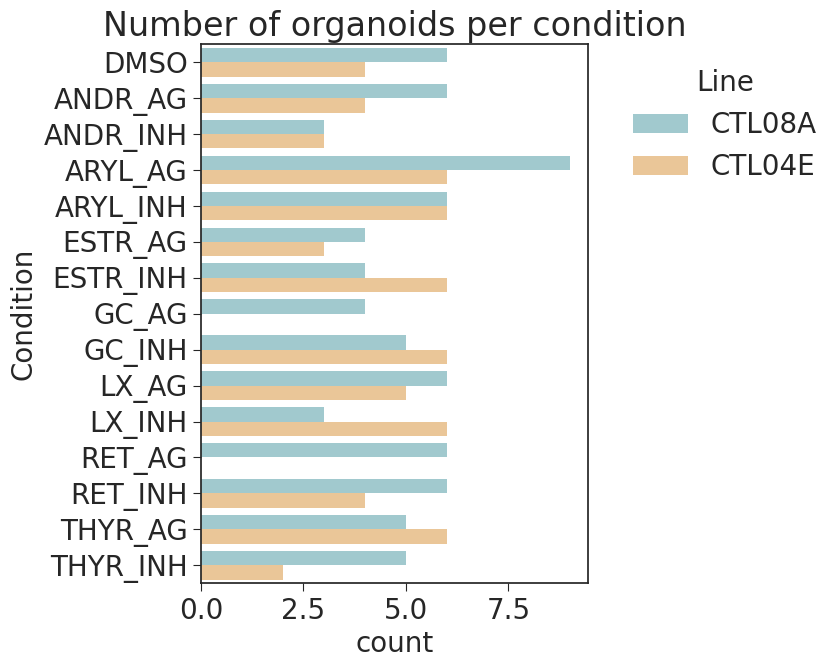

In [353]:
to_plot = organoid_areas.loc[[i for i in good_tissue_to_keep_limit if i in organoid_areas.index]]
to_plot = to_plot[['Condition', 'Line']].value_counts().reset_index()
plt.figure(figsize = (5, 7))
sns.barplot(to_plot, x='count', y='Condition', hue='Line', order = hormonal_conditions, palette=line_palette)
plt.title('Number of organoids per condition')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('../../endpoints_figures/organoid_count_per_condition.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/organoid_count_per_condition.png', dpi=300, bbox_inches='tight')

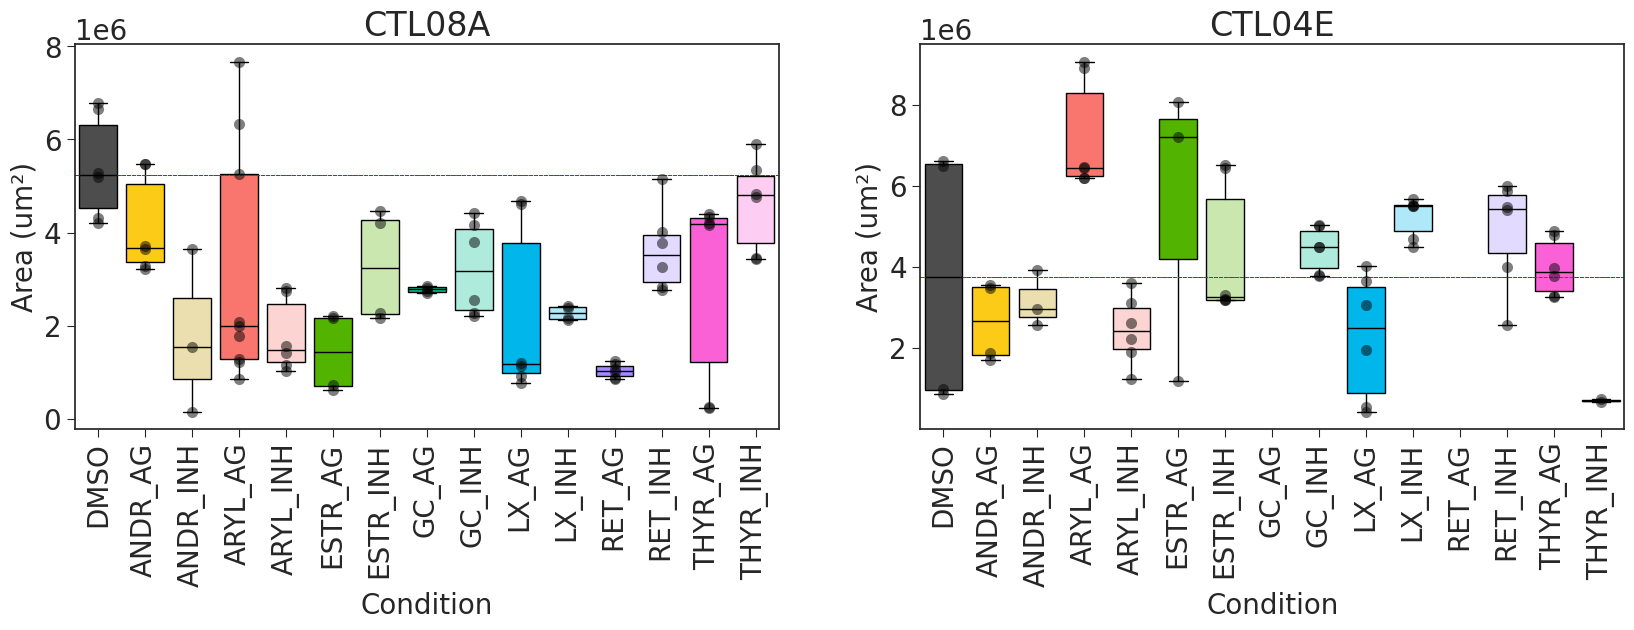

In [354]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
organoid_areas = organoid_areas[organoid_areas['Condition'].isin(hormonal_conditions)]
for i, cond in enumerate(hormonal_conditions):
    data = organoid_areas[(organoid_areas['Line'] == 'CTL08A') & 
                                 (organoid_areas['Condition'] == cond)]['Area_um2']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = organoid_areas[(organoid_areas['Condition'] == 'DMSO') & 
                                       (organoid_areas['Line'] == 'CTL08A')]['Area_um2'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=organoid_areas[(organoid_areas['Line'] == 'CTL08A')],
    y='Area_um2', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = organoid_areas[(organoid_areas['Line'] == 'CTL04E') & 
                                 (organoid_areas['Condition'] == cond)]['Area_um2']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = organoid_areas[(organoid_areas['Condition'] == 'DMSO') & 
                                       (organoid_areas['Line'] == 'CTL04E')]['Area_um2'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=organoid_areas[organoid_areas['Line'] == 'CTL04E'],
    y='Area_um2', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('Area (um²)')
ax[1].set_ylabel('Area (um²)')

plt.savefig('../../endpoints_figures/endpoints_organoids_area_grouped.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/endpoints_organoids_area_grouped.png', dpi=300, bbox_inches='tight')

## Compute density

In [355]:
n_nuclei_mix1 = pd.read_csv('../tables/n_nuclei_mix1.csv')
n_nuclei_mix2 = pd.read_csv('../tables/n_nuclei_mix2.csv')
n_nuclei = pd.concat([n_nuclei_mix1, n_nuclei_mix2])

In [356]:
n_nuclei.ImageName = n_nuclei.ImageName.str.replace('_channel_1', '')

In [357]:
n_nuclei.set_index('ImageName', inplace = True)

In [358]:
organoid_areas['n_nuclei'] = n_nuclei['count']

In [359]:
organoid_areas['density'] = organoid_areas['n_nuclei'] / organoid_areas['Area_um2']

## Number of nuclei per condition and line

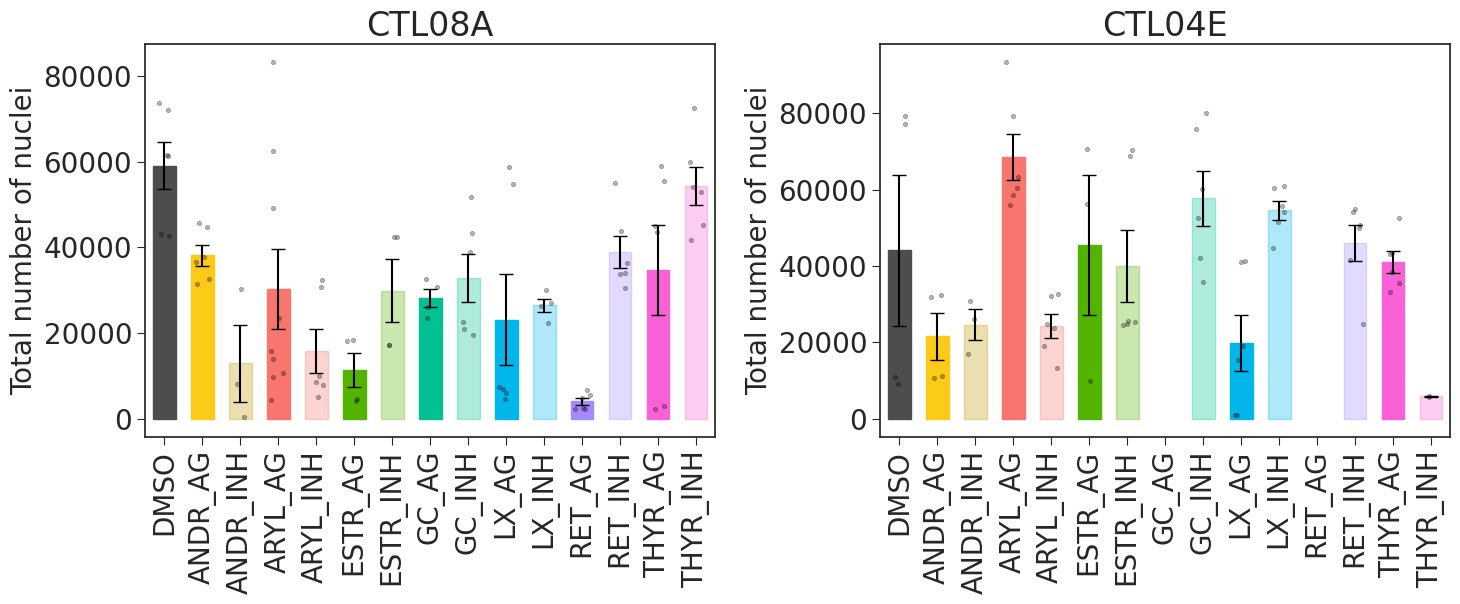

In [461]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
bar_width = 0.6

for ax, line in zip(axs, ['CTL08A', 'CTL04E']):
    df = organoid_areas[organoid_areas['Line'] == line]
    means = df.groupby('Condition')['n_nuclei'].mean().reindex(hormonal_conditions)
    sems = df.groupby('Condition')['n_nuclei'].sem().reindex(hormonal_conditions)

    x = np.arange(len(hormonal_conditions))

    for i, cond in enumerate(hormonal_conditions):
        mean = means[cond]
        sem = sems[cond]

        # Add bar as a Rectangle
        bar = Rectangle(
            (i - bar_width / 2, 0),  # bottom-left x, y
            bar_width,
            mean,
            color=color_palette[cond],
            zorder=1
        )
        ax.add_patch(bar)

        # Add error bar
        ax.errorbar(
            i, mean, yerr=sem,
            fmt='none',
            ecolor='black',
            capsize=5,
            zorder=2
        )

        # Add strip dots
        y_vals = df[df['Condition'] == cond]['n_nuclei']
        jittered_x = i + np.random.uniform(-bar_width/3, bar_width/3, size=len(y_vals))
        ax.scatter(jittered_x, y_vals, color='black', alpha=0.3, s=10, linewidth=0.5, zorder=3)

    # Format
    ax.set_title(line)
    ax.set_xticks(x)
    ax.set_xticklabels(hormonal_conditions, rotation=90)
    ax.set_xlim(-0.5, len(hormonal_conditions) - 0.5)
    ax.set_ylabel("Total number of nuclei")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('../../endpoints_figures/number_of_nuclei_per_condition.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/number_of_nuclei_per_condition.png', dpi=300, bbox_inches='tight')
plt.show()

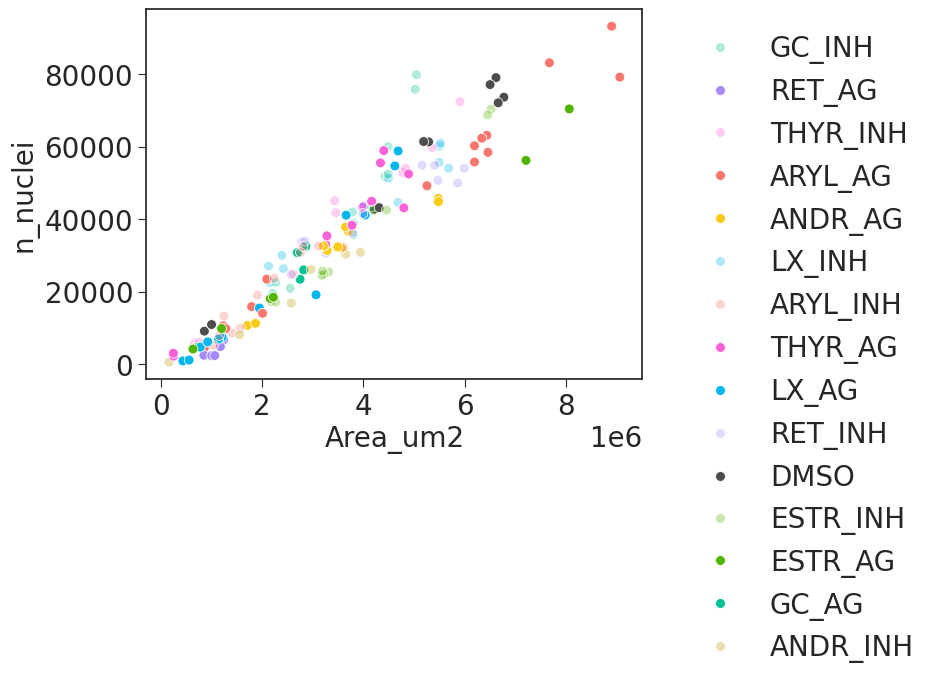

In [361]:
sns.scatterplot(x = organoid_areas['Area_um2'], y = organoid_areas['n_nuclei'], s=50, hue = organoid_areas['Condition'], palette=color_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('../../endpoints_figures/scatterplot_area_n_nuclei.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/scatterplot_area_n_nuclei.png', dpi=300, bbox_inches='tight')

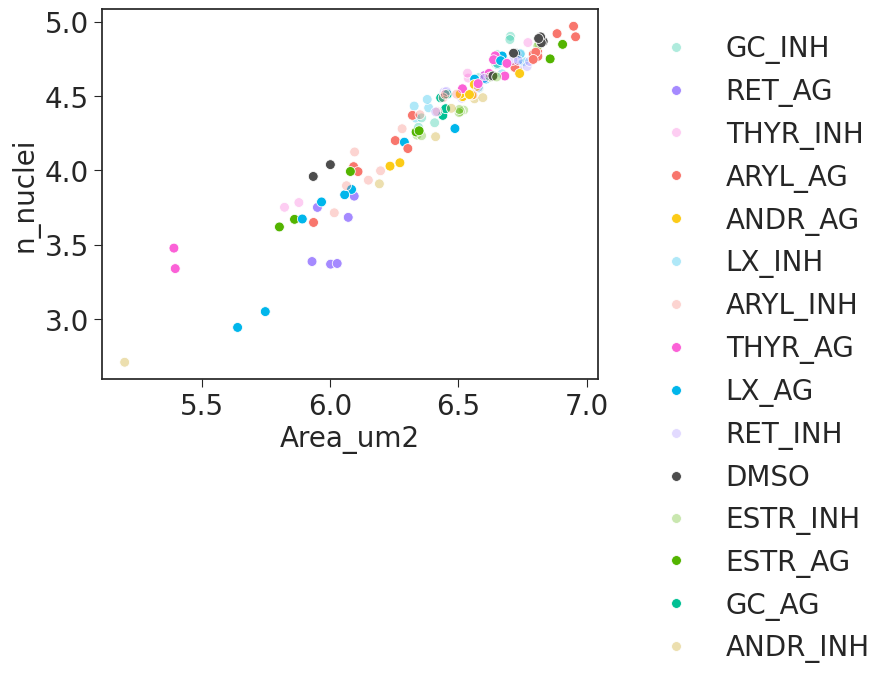

In [362]:
sns.scatterplot(x = np.log10(organoid_areas['Area_um2']), y = np.log10(organoid_areas['n_nuclei']), s=50, hue = organoid_areas['Condition'], palette=color_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.savefig('../../endpoints_figures/scatterplot_area_n_nuclei.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/scatterplot_area_n_nuclei.png', dpi=300, bbox_inches='tight')

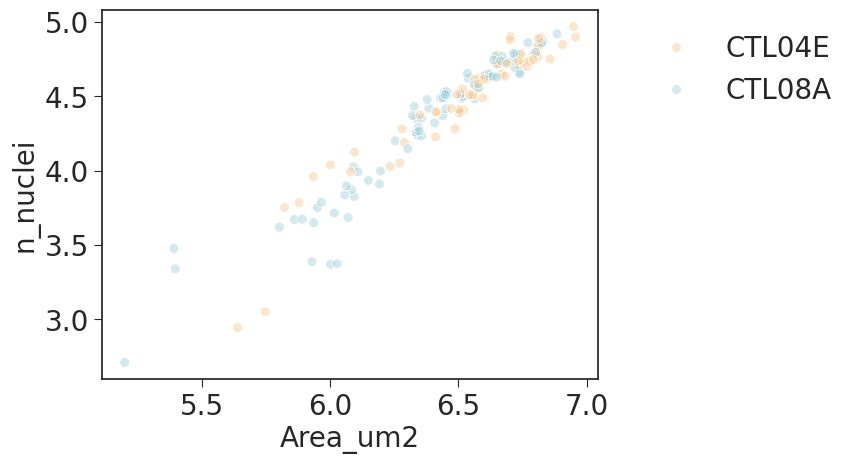

In [363]:
sns.scatterplot(x = np.log10(organoid_areas['Area_um2']), y = np.log10(organoid_areas['n_nuclei']), s=50, hue = organoid_areas['Line'], palette=line_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

## Plot of density

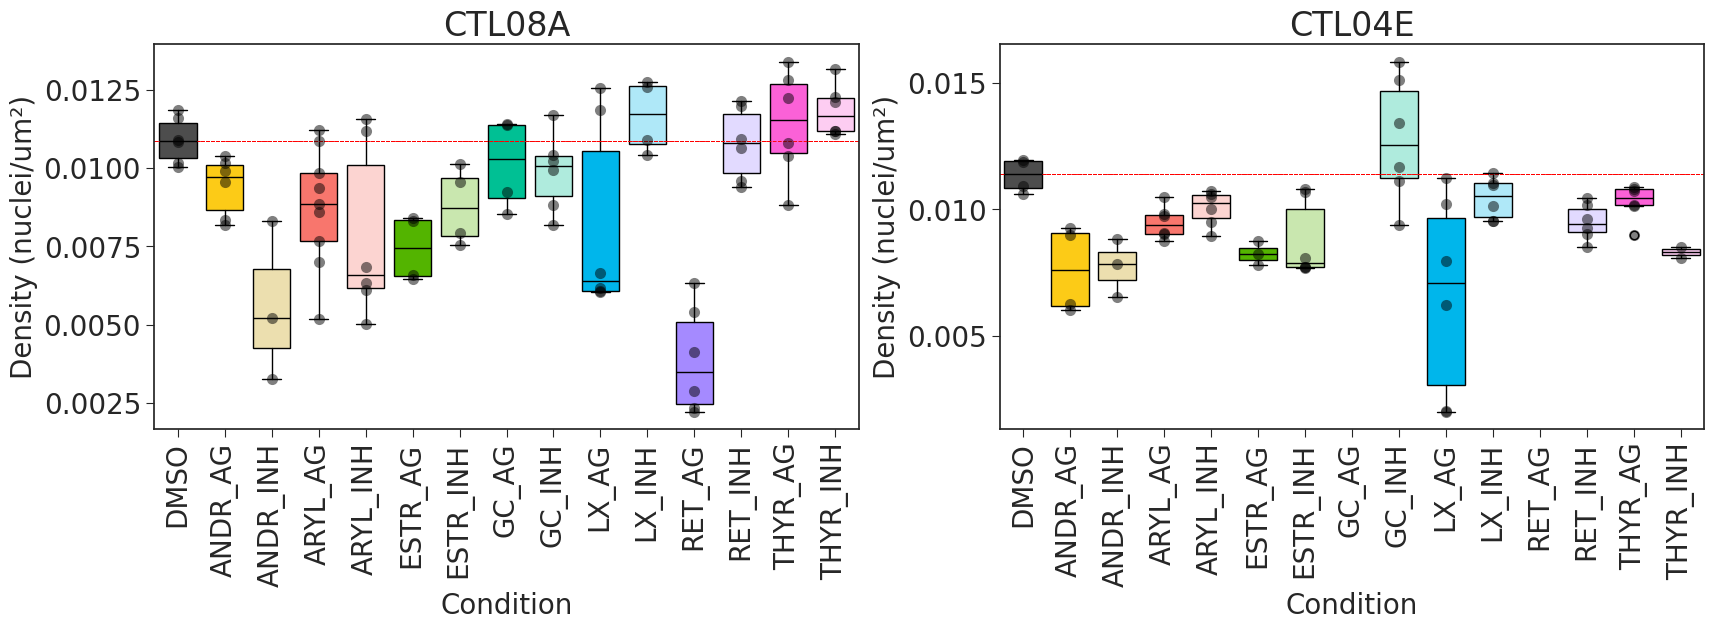

In [364]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
organoid_areas = organoid_areas[organoid_areas['Condition'].isin(hormonal_conditions)]
for i, cond in enumerate(hormonal_conditions):
    data = organoid_areas[(organoid_areas['Line'] == 'CTL08A') & 
                                 (organoid_areas['Condition'] == cond)]['density']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = organoid_areas[(organoid_areas['Condition'] == 'DMSO') & 
                                       (organoid_areas['Line'] == 'CTL08A')]['density'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=organoid_areas[(organoid_areas['Line'] == 'CTL08A')],
    y='density', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = organoid_areas[(organoid_areas['Line'] == 'CTL04E') & 
                                 (organoid_areas['Condition'] == cond)]['density']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = organoid_areas[(organoid_areas['Condition'] == 'DMSO') & 
                                       (organoid_areas['Line'] == 'CTL04E')]['density'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=organoid_areas[organoid_areas['Line'] == 'CTL04E'],
    y='density', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('Density (nuclei/um²)')
ax[1].set_ylabel('Density (nuclei/um²)')

plt.savefig('../../endpoints_figures/endpoints_organoids_density_grouped.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/endpoints_organoids_density_grouped.png', dpi=300, bbox_inches='tight')

In [365]:
density_dict = {i:j for i, j in zip(organoid_areas.index, organoid_areas['density'])}
area_dict = {i:j for i, j in zip(organoid_areas.index, organoid_areas['Area_um2'])}

# MIX 1

## Channel 2 - SOX2

In [366]:
tot_df_mix1_ch2 = pd.DataFrame()
measurements_files_mix_1_ch2 = [f for f in measurements_files_mix_1 if 'channel_2' in f]

for file in measurements_files_mix_1_ch2:
    print(file)
    df = pd.read_csv(file, index_col=0)
    df['ImageName'] = file.split("/")[-1].split(".")[0]
    print(df.shape)
    tot_df_mix1_ch2 = pd.concat([tot_df_mix1_ch2, df], axis=0)

/group/testa/Project/EndPoints/TPSSU/analysis/measurements/20240424_manuel_lessi_0129_ScanRegion3_rep_1_channel_2_measures.csv
(14032, 19)
/group/testa/Project/EndPoints/TPSSU/analysis/measurements/20240424_manuel_lessi_0134_ScanRegion2_rep_0_channel_2_measures.csv
(36257, 19)
/group/testa/Project/EndPoints/TPSSU/analysis/measurements/20240424_manuel_lessi_0134_ScanRegion3_rep_1_channel_2_measures.csv
(29165, 19)
/group/testa/Project/EndPoints/TPSSU/analysis/measurements/20240424_manuel_lessi_0133_ScanRegion2_rep_0_channel_2_measures.csv
(28234, 19)
/group/testa/Project/EndPoints/TPSSU/analysis/measurements/20240424_manuel_lessi_0129_ScanRegion1_rep_2_channel_2_measures.csv
(5186, 19)
/group/testa/Project/EndPoints/TPSSU/analysis/measurements/20240424_manuel_lessi_0134_ScanRegion2_rep_1_channel_2_measures.csv
(30598, 19)
/group/testa/Project/EndPoints/TPSSU/analysis/measurements/20240424_manuel_lessi_0129_ScanRegion0_rep_0_channel_2_measures.csv
(4420, 19)
/group/testa/Project/EndPoint

In [367]:
#tot_df_mix1_ch2.to_csv("/group/testa/Project/EndPoints/TPSSU/analysis/measurements_mix_1_ch2_SOX2.csv")

### Thresholding

In [368]:
tot_pos_SOX2 = {}
density_SOX2 = {}
n_nuclei = {}
n_nuclei_tot_pos_SOX2 = {}

for file in measurements_files_mix_1_ch2:
    #print(file)
    df = pd.read_csv(file, index_col=0)
    
    imageName_scanRegion_rep = file.split('/')[-1].split('.')[0].replace('_channel_2_measures', '')
    imageName_scanRegion = '_'.join(imageName_scanRegion_rep.split('_')[:5])
    
    if imageName_scanRegion_rep in good_tissue_to_keep_limit and imageName_scanRegion in sample_sheet['ImageName_ScanRegion'].values:
        area = area_dict[imageName_scanRegion_rep]
        
        df['ImageName'] = file.split("/")[-1].split(".")[0]
        tot_pos_SOX2[file.split("/")[-1].split(".")[0]] = {}
        density_SOX2[imageName_scanRegion_rep] = {}
        n_nuclei_tot_pos_SOX2[imageName_scanRegion_rep] = {}

        min_quantile = np.quantile(df['area'], 0.01)

        max_quantile = np.quantile(df['area'], 0.99)

        df = df[(df['area'] > min_quantile) & (df['area'] < max_quantile)]

        n_nuclei[file.split("/")[-1].split(".")[0]] = df.shape[0]

        otsu_thrs = filters.threshold_multiotsu(np.array(df['intensity_mean']), classes = 4)

        for i, thr in enumerate(otsu_thrs):
            tot_pos_SOX2[file.split("/")[-1].split(".")[0]][f'otsu_{i}'] = np.sum(df['intensity_mean'] > thr) / df.shape[0] * 100
            n_nuclei_tot_pos_SOX2[imageName_scanRegion_rep][f'otsu_{i}'] = np.sum(df['intensity_mean'] > thr)
            density_SOX2[imageName_scanRegion_rep][f'otsu_{i}'] = np.sum(df['intensity_mean'] > thr) / area * 100
            

In [369]:
df_percentages = pd.DataFrame.from_dict(tot_pos_SOX2, orient='index')
df_percentages['ImageName_ScanRegion'] = df_percentages.reset_index()['index'].apply(lambda x: '_'.join(x.split('_')[0:5])).values
df_percentages['ImageName_ScanRegion_rep'] = df_percentages.reset_index()['index'].apply(lambda x: '_'.join(x.split('_')[0:7])).values
df_percentages['Condition_Line'] = df_percentages['ImageName_ScanRegion'].map(sample_dict)
df_percentages = df_percentages[~df_percentages.Condition_Line.isna()]
df_percentages['Line'] = df_percentages['Condition_Line'].apply(lambda x: x.split('_')[-1])
df_percentages['Condition'] = df_percentages['Condition_Line'].str.replace('_CTL08A', '', regex=True)
df_percentages['Condition'] = df_percentages['Condition'].str.replace('_CTL04E', '', regex=True)

#df_percentages = pd.read_csv("/group/testa/Project/EndPoints/TPSSU/analysis/percentages_mix_1_ch2_SOX2_percentages.csv")

In [370]:
sox2_pos_cells = pd.DataFrame.from_dict(n_nuclei_tot_pos_SOX2, orient='index')
sox2_pos_cells['ImageName_ScanRegion'] = sox2_pos_cells.reset_index()['index'].apply(lambda x: '_'.join(x.split('_')[0:5])).values
sox2_pos_cells['ImageName_ScanRegion_rep'] = sox2_pos_cells.reset_index()['index'].apply(lambda x: '_'.join(x.split('_')[0:7])).values
sox2_pos_cells['Condition_Line'] = sox2_pos_cells['ImageName_ScanRegion'].map(sample_dict)
sox2_pos_cells = sox2_pos_cells[~sox2_pos_cells.Condition_Line.isna()]
sox2_pos_cells['Line'] = sox2_pos_cells['Condition_Line'].apply(lambda x: x.split('_')[-1])
sox2_pos_cells['Condition'] = sox2_pos_cells['Condition_Line'].str.replace('_CTL08A', '', regex=True)
sox2_pos_cells['Condition'] = sox2_pos_cells['Condition'].str.replace('_CTL04E', '', regex=True)
sox2_pos_cells

,otsu_0,otsu_1,otsu_2,ImageName_ScanRegion,ImageName_ScanRegion_rep,Condition_Line,Line,Condition
20240424_manuel_lessi_0129_ScanRegion3_rep_1,2907,1209,365,20240424_manuel_lessi_0129_ScanRegion3,20240424_manuel_lessi_0129_ScanRegion3_rep_1,ARYL_AG_CTL08A,CTL08A,ARYL_AG
20240424_manuel_lessi_0134_ScanRegion2_rep_0,9181,3059,783,20240424_manuel_lessi_0134_ScanRegion2,20240424_manuel_lessi_0134_ScanRegion2_rep_0,RET_INH_CTL08A,CTL08A,RET_INH
20240424_manuel_lessi_0129_ScanRegion1_rep_2,301,144,36,20240424_manuel_lessi_0129_ScanRegion1,20240424_manuel_lessi_0129_ScanRegion1_rep_2,ARYL_INH_CTL08A,CTL08A,ARYL_INH
20240424_manuel_lessi_0134_ScanRegion2_rep_1,9830,3475,872,20240424_manuel_lessi_0134_ScanRegion2,20240424_manuel_lessi_0134_ScanRegion2_rep_1,RET_INH_CTL08A,CTL08A,RET_INH
20240424_manuel_lessi_0133_ScanRegion4_rep_0,3333,1923,522,20240424_manuel_lessi_0133_ScanRegion4,20240424_manuel_lessi_0133_ScanRegion4_rep_0,RET_AG_CTL08A,CTL08A,RET_AG
...,...,...,...,...,...,...,...,...
20240424_manuel_lessi_0130_ScanRegion3_rep_1,22897,12283,4331,20240424_manuel_lessi_0130_ScanRegion3,20240424_manuel_lessi_0130_ScanRegion3_rep_1,LX_INH_CTL04E,CTL04E,LX_INH
20240424_manuel_lessi_0133_ScanRegion4_rep_1,1685,884,260,20240424_manuel_lessi_0133_ScanRegion4,20240424_manuel_lessi_0133_ScanRegion4_rep_1,RET_AG_CTL08A,CTL08A,RET_AG
20240424_manuel_lessi_0130_ScanRegion0_rep_0,10199,5549,1924,20240424_manuel_lessi_0130_ScanRegion0,20240424_manuel_lessi_0130_ScanRegion0_rep_0,LX_AG_CTL04E,CTL04E,LX_AG
20240424_manuel_lessi_0129_ScanRegion3_rep_3,3898,2172,762,20240424_manuel_lessi_0129_ScanRegion3,20240424_manuel_lessi_0129_ScanRegion3_rep_3,ARYL_AG_CTL08A,CTL08A,ARYL_AG


In [371]:
density_SOX2 = pd.DataFrame.from_dict(density_SOX2, orient='index').reset_index()
density_SOX2['ImageName_ScanRegion'] = density_SOX2['index'].apply(lambda x: '_'.join(x.split('_')[0:5]))
density_SOX2['ImageName_ScanRegion_rep'] = density_SOX2['index'].apply(lambda x: '_'.join(x.split('_')[0:7]))
density_SOX2['Condition_Line'] = density_SOX2['ImageName_ScanRegion'].map(sample_dict)
density_SOX2 = density_SOX2[~density_SOX2.Condition_Line.isna()]
density_SOX2['Line'] = density_SOX2['Condition_Line'].apply(lambda x: x.split('_')[-1])
density_SOX2['Condition'] = density_SOX2['Condition_Line'].str.replace('_CTL08A', '', regex=True)
density_SOX2['Condition'] = density_SOX2['Condition'].str.replace('_CTL04E', '', regex=True)

print(len(density_SOX2))
#density_SOX2.to_csv("/group/testa/Project/EndPoints/TPSSU/analysis/SOX2_pos_over_area_mix_1_ch2.csv")

65


In [372]:
n_nuclei = pd.DataFrame.from_dict(n_nuclei, orient='index').reset_index()
n_nuclei['ImageName_ScanRegion'] = n_nuclei['index'].apply(lambda x: '_'.join(x.split('_')[0:5]))
n_nuclei['ImageName_ScanRegion_rep'] = n_nuclei['index'].apply(lambda x: '_'.join(x.split('_')[0:7]))
n_nuclei['Condition_Line'] = n_nuclei['ImageName_ScanRegion'].map(sample_dict)
n_nuclei = n_nuclei[~n_nuclei.Condition_Line.isna()]
n_nuclei['Line'] = n_nuclei['Condition_Line'].apply(lambda x: x.split('_')[-1])
n_nuclei['Condition'] = n_nuclei['Condition_Line'].str.replace('_CTL08A', '', regex=True)
n_nuclei['Condition'] = n_nuclei['Condition'].str.replace('_CTL04E', '', regex=True)


### Plots
#### Percentages

In [373]:
mix1_img_names = tot_df_mix1_ch2['ImageName'].apply(lambda x: '_'.join(x.split('_')[0:4])).value_counts().index.tolist()

In [374]:
check_qc_ch2['ImageName_ScanRegion'] = check_qc_ch2['Reference Image Report'].apply(lambda x: '_'.join(x.split('_')[0:5]))
check_qc_ch2['ImageName_ScanRegion_rep'] = check_qc_ch2['Reference Image Report'].apply(lambda x: '_'.join(x.split('_')[0:7]))
check_qc_ch2['ImageName'] = check_qc_ch2['Reference Image Report'].apply(lambda x: '_'.join(x.split('_')[0:4]))
check_qc_ch2_mix1 = check_qc_ch2[check_qc_ch2['ImageName'].isin(mix1_img_names)]

In [375]:
check_qc_ch2_mix1['general QC (keep or not)'].value_counts()

general QC (keep or not)
YES      86
NO       15
LIMIT     6
Name: count, dtype: int64

In [376]:
check_qc_ch2_mix1

,Reference Image Report,general QC (keep or not),ImageName_ScanRegion_Rep,ImageName_ScanRegion,ImageName_ScanRegion_rep,ImageName
0,20240424_manuel_lessi_0128_ScanRegion0_rep_0_c...,YES,20240424_manuel_lessi_0128_ScanRegion0_rep_0,20240424_manuel_lessi_0128_ScanRegion0,20240424_manuel_lessi_0128_ScanRegion0_rep_0,20240424_manuel_lessi_0128
1,20240424_manuel_lessi_0128_ScanRegion0_rep_1_c...,YES,20240424_manuel_lessi_0128_ScanRegion0_rep_1,20240424_manuel_lessi_0128_ScanRegion0,20240424_manuel_lessi_0128_ScanRegion0_rep_1,20240424_manuel_lessi_0128
2,20240424_manuel_lessi_0128_ScanRegion1_rep_0_c...,YES,20240424_manuel_lessi_0128_ScanRegion1_rep_0,20240424_manuel_lessi_0128_ScanRegion1,20240424_manuel_lessi_0128_ScanRegion1_rep_0,20240424_manuel_lessi_0128
3,20240424_manuel_lessi_0128_ScanRegion1_rep_1_c...,YES,20240424_manuel_lessi_0128_ScanRegion1_rep_1,20240424_manuel_lessi_0128_ScanRegion1,20240424_manuel_lessi_0128_ScanRegion1_rep_1,20240424_manuel_lessi_0128
4,20240424_manuel_lessi_0128_ScanRegion2_rep_0_c...,YES,20240424_manuel_lessi_0128_ScanRegion2_rep_0,20240424_manuel_lessi_0128_ScanRegion2,20240424_manuel_lessi_0128_ScanRegion2_rep_0,20240424_manuel_lessi_0128
...,...,...,...,...,...,...
102,20240424_manuel_lessi_0134_ScanRegion4_rep_2_c...,NO,20240424_manuel_lessi_0134_ScanRegion4_rep_2,20240424_manuel_lessi_0134_ScanRegion4,20240424_manuel_lessi_0134_ScanRegion4_rep_2,20240424_manuel_lessi_0134
103,20240424_manuel_lessi_0134_ScanRegion5_rep_0_c...,NO,20240424_manuel_lessi_0134_ScanRegion5_rep_0,20240424_manuel_lessi_0134_ScanRegion5,20240424_manuel_lessi_0134_ScanRegion5_rep_0,20240424_manuel_lessi_0134
104,20240424_manuel_lessi_0134_ScanRegion6_rep_0_c...,YES,20240424_manuel_lessi_0134_ScanRegion6_rep_0,20240424_manuel_lessi_0134_ScanRegion6,20240424_manuel_lessi_0134_ScanRegion6_rep_0,20240424_manuel_lessi_0134
105,20240424_manuel_lessi_0134_ScanRegion6_rep_2_c...,NO,20240424_manuel_lessi_0134_ScanRegion6_rep_2,20240424_manuel_lessi_0134_ScanRegion6,20240424_manuel_lessi_0134_ScanRegion6_rep_2,20240424_manuel_lessi_0134


In [377]:
to_remove = check_qc_ch2_mix1[check_qc_ch2_mix1['general QC (keep or not)'] == 'NO']['ImageName_ScanRegion_rep'].tolist()
len(to_remove)

15

In [378]:
df_percentages = df_percentages[~df_percentages['ImageName_ScanRegion_rep'].isin(to_remove)]
len(df_percentages)

65

In [379]:
sox2_pos_cells = sox2_pos_cells[~sox2_pos_cells['ImageName_ScanRegion_rep'].isin(to_remove)]
len(sox2_pos_cells)

65

In [380]:
n_nuclei = n_nuclei[~n_nuclei['ImageName_ScanRegion_rep'].isin(to_remove)]
len(n_nuclei)

65

In [381]:
order = df_percentages['Condition'].tolist()
order = list(dict.fromkeys(order))  # Remove duplicates while preserving order
order.remove('DMSO')
order.sort()
order = ['DMSO'] + order

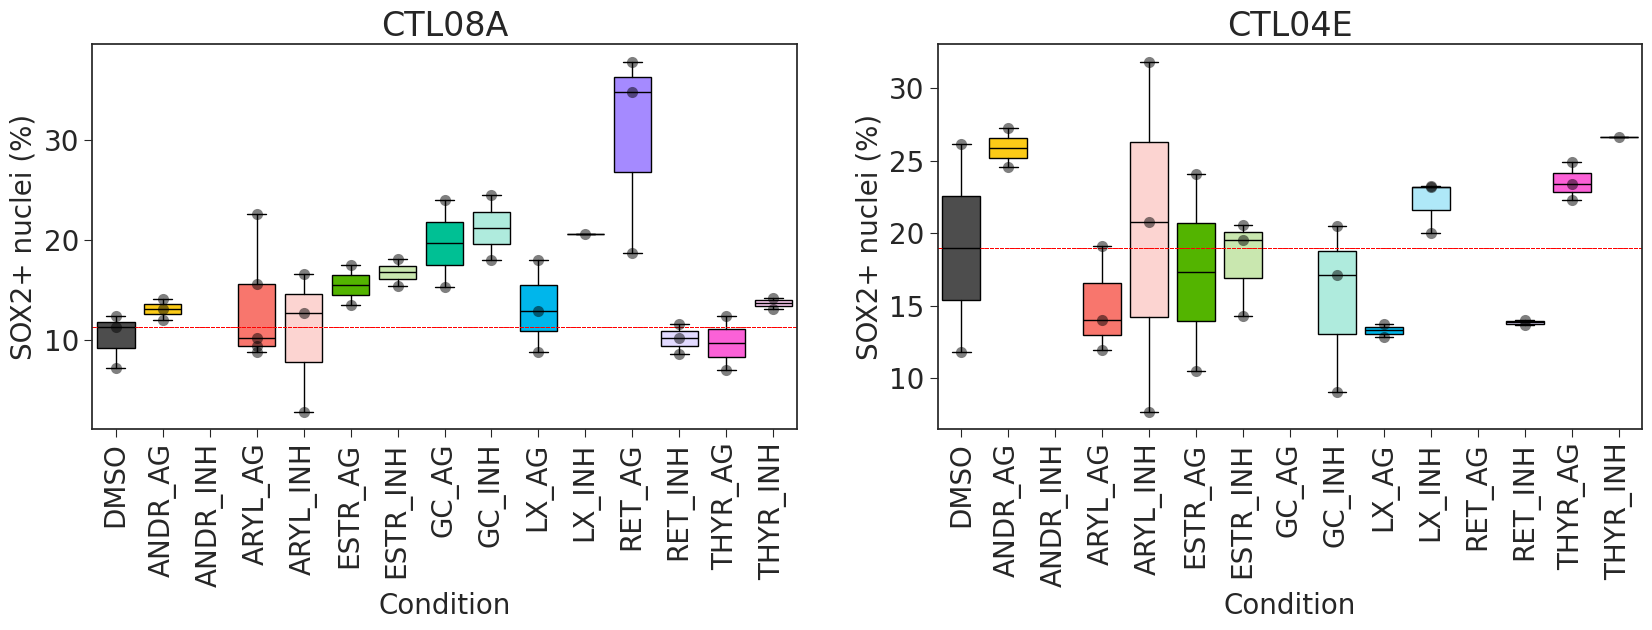

In [382]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for i, cond in enumerate(hormonal_conditions):
    data = df_percentages[(df_percentages['Line'] == 'CTL08A') & 
                                 (df_percentages['Condition'] == cond)]['otsu_1']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = df_percentages[(df_percentages['Condition'] == 'DMSO') & 
                                       (df_percentages['Line'] == 'CTL08A')]['otsu_1'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df_percentages[(df_percentages['Line'] == 'CTL08A')],
    y='otsu_1', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = df_percentages[(df_percentages['Line'] == 'CTL04E') & 
                                 (df_percentages['Condition'] == cond)]['otsu_1']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = df_percentages[(df_percentages['Condition'] == 'DMSO') & 
                                       (df_percentages['Line'] == 'CTL04E')]['otsu_1'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df_percentages[df_percentages['Line'] == 'CTL04E'],
    y='otsu_1', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('SOX2+ nuclei (%)')
ax[1].set_ylabel('SOX2+ nuclei (%)')

plt.savefig('../../endpoints_figures/SOX2_pos_otsu_1_per_condition.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/SOX2_pos_otsu_1_per_condition.png', dpi=300, bbox_inches='tight')

In [383]:
df_percentages[df_percentages.Condition.isin(['RET_AG', 'DMSO'])][['otsu_1', 'Condition']].sort_values(by='Condition', ascending=False)

,otsu_1,Condition
20240424_manuel_lessi_0133_ScanRegion4_rep_0_channel_2_measures,34.818034,RET_AG
20240424_manuel_lessi_0133_ScanRegion4_rep_2_channel_2_measures,37.808219,RET_AG
20240424_manuel_lessi_0133_ScanRegion4_rep_1_channel_2_measures,18.673426,RET_AG
20240424_manuel_lessi_0132_ScanRegion5_rep_0_channel_2_measures,11.246140,DMSO
20240424_manuel_lessi_0132_ScanRegion5_rep_2_channel_2_measures,12.400583,DMSO
20240424_manuel_lessi_0132_ScanRegion4_rep_1_channel_2_measures,26.132437,DMSO
20240424_manuel_lessi_0132_ScanRegion5_rep_1_channel_2_measures,7.145889,DMSO
20240424_manuel_lessi_0132_ScanRegion4_rep_0_channel_2_measures,11.837556,DMSO


In [384]:
sox2_pos_cells[sox2_pos_cells.Condition.isin(['RET_AG', 'DMSO'])][['otsu_1', 'Condition']].sort_values(by='Condition', ascending=False)

,otsu_1,Condition
20240424_manuel_lessi_0133_ScanRegion4_rep_0,1923,RET_AG
20240424_manuel_lessi_0133_ScanRegion4_rep_2,2484,RET_AG
20240424_manuel_lessi_0133_ScanRegion4_rep_1,884,RET_AG
20240424_manuel_lessi_0132_ScanRegion5_rep_0,6774,DMSO
20240424_manuel_lessi_0132_ScanRegion5_rep_2,5192,DMSO
20240424_manuel_lessi_0132_ScanRegion4_rep_1,2798,DMSO
20240424_manuel_lessi_0132_ScanRegion5_rep_1,5051,DMSO
20240424_manuel_lessi_0132_ScanRegion4_rep_0,9176,DMSO


In [385]:
df_percentages[df_percentages.Condition.isin(['RET_AG', 'DMSO'])][['otsu_1', 'Condition']].sort_values(by='Condition', ascending=False).groupby('Condition').median()

,otsu_1
Condition,
DMSO,11.837556
RET_AG,34.818034


In [386]:
sox2_pos_cells[sox2_pos_cells.Condition.isin(['RET_AG', 'DMSO'])][['otsu_1', 'Condition']].sort_values(by='Condition', ascending=False).groupby('Condition').median()

,otsu_1
Condition,
DMSO,5192.0
RET_AG,1923.0


In [387]:
sox2_pos_cells

,otsu_0,otsu_1,otsu_2,ImageName_ScanRegion,ImageName_ScanRegion_rep,Condition_Line,Line,Condition
20240424_manuel_lessi_0129_ScanRegion3_rep_1,2907,1209,365,20240424_manuel_lessi_0129_ScanRegion3,20240424_manuel_lessi_0129_ScanRegion3_rep_1,ARYL_AG_CTL08A,CTL08A,ARYL_AG
20240424_manuel_lessi_0134_ScanRegion2_rep_0,9181,3059,783,20240424_manuel_lessi_0134_ScanRegion2,20240424_manuel_lessi_0134_ScanRegion2_rep_0,RET_INH_CTL08A,CTL08A,RET_INH
20240424_manuel_lessi_0129_ScanRegion1_rep_2,301,144,36,20240424_manuel_lessi_0129_ScanRegion1,20240424_manuel_lessi_0129_ScanRegion1_rep_2,ARYL_INH_CTL08A,CTL08A,ARYL_INH
20240424_manuel_lessi_0134_ScanRegion2_rep_1,9830,3475,872,20240424_manuel_lessi_0134_ScanRegion2,20240424_manuel_lessi_0134_ScanRegion2_rep_1,RET_INH_CTL08A,CTL08A,RET_INH
20240424_manuel_lessi_0133_ScanRegion4_rep_0,3333,1923,522,20240424_manuel_lessi_0133_ScanRegion4,20240424_manuel_lessi_0133_ScanRegion4_rep_0,RET_AG_CTL08A,CTL08A,RET_AG
...,...,...,...,...,...,...,...,...
20240424_manuel_lessi_0130_ScanRegion3_rep_1,22897,12283,4331,20240424_manuel_lessi_0130_ScanRegion3,20240424_manuel_lessi_0130_ScanRegion3_rep_1,LX_INH_CTL04E,CTL04E,LX_INH
20240424_manuel_lessi_0133_ScanRegion4_rep_1,1685,884,260,20240424_manuel_lessi_0133_ScanRegion4,20240424_manuel_lessi_0133_ScanRegion4_rep_1,RET_AG_CTL08A,CTL08A,RET_AG
20240424_manuel_lessi_0130_ScanRegion0_rep_0,10199,5549,1924,20240424_manuel_lessi_0130_ScanRegion0,20240424_manuel_lessi_0130_ScanRegion0_rep_0,LX_AG_CTL04E,CTL04E,LX_AG
20240424_manuel_lessi_0129_ScanRegion3_rep_3,3898,2172,762,20240424_manuel_lessi_0129_ScanRegion3,20240424_manuel_lessi_0129_ScanRegion3_rep_3,ARYL_AG_CTL08A,CTL08A,ARYL_AG


In [388]:
check_area_df = organoid_areas.loc[sox2_pos_cells.ImageName_ScanRegion_rep.tolist()]
check_area_df

,area,ImageName_ScanRegion,Condition_Line,Line,Condition,Area_um2,n_nuclei,density
20240424_manuel_lessi_0129_ScanRegion3_rep_1,18992894,20240424_manuel_lessi_0129_ScanRegion3,ARYL_AG_CTL08A,CTL08A,ARYL_AG,2.006124e+06,14032,0.006995
20240424_manuel_lessi_0134_ScanRegion2_rep_0,35827100,20240424_manuel_lessi_0134_ScanRegion2,RET_INH_CTL08A,CTL08A,RET_INH,3.784237e+06,36257,0.009581
20240424_manuel_lessi_0129_ScanRegion1_rep_2,9802711,20240424_manuel_lessi_0129_ScanRegion1,ARYL_INH_CTL08A,CTL08A,ARYL_INH,1.035411e+06,5186,0.005009
20240424_manuel_lessi_0134_ScanRegion2_rep_1,30831525,20240424_manuel_lessi_0134_ScanRegion2,RET_INH_CTL08A,CTL08A,RET_INH,3.256580e+06,30598,0.009396
20240424_manuel_lessi_0133_ScanRegion4_rep_0,8422522,20240424_manuel_lessi_0133_ScanRegion4,RET_AG_CTL08A,CTL08A,RET_AG,8.896289e+05,5637,0.006336
...,...,...,...,...,...,...,...,...
20240424_manuel_lessi_0130_ScanRegion3_rep_1,53795625,20240424_manuel_lessi_0130_ScanRegion3,LX_INH_CTL04E,CTL04E,LX_INH,5.682163e+06,54110,0.009523
20240424_manuel_lessi_0133_ScanRegion4_rep_1,11112634,20240424_manuel_lessi_0133_ScanRegion4,RET_AG_CTL08A,CTL08A,RET_AG,1.173772e+06,4832,0.004117
20240424_manuel_lessi_0130_ScanRegion0_rep_0,38195586,20240424_manuel_lessi_0130_ScanRegion0,LX_AG_CTL04E,CTL04E,LX_AG,4.034409e+06,41176,0.010206
20240424_manuel_lessi_0129_ScanRegion3_rep_3,12134498,20240424_manuel_lessi_0129_ScanRegion3,ARYL_AG_CTL08A,CTL08A,ARYL_AG,1.281706e+06,9818,0.007660


In [389]:
check_area_df[check_area_df.Condition.isin(['RET_AG', 'DMSO'])][['area', 'Condition']].sort_values(by='Condition', ascending=False).groupby('Condition').median()

,area
Condition,
DMSO,49127353.0
RET_AG,11112634.0


In [390]:
n_nuclei[n_nuclei.Condition.isin(['RET_AG', 'DMSO'])][[0, 'Condition']].sort_values(by='Condition', ascending=False).groupby('Condition').median()

,0
Condition,
DMSO,60234.0
RET_AG,5523.0


#### SOX2+ / organoid area

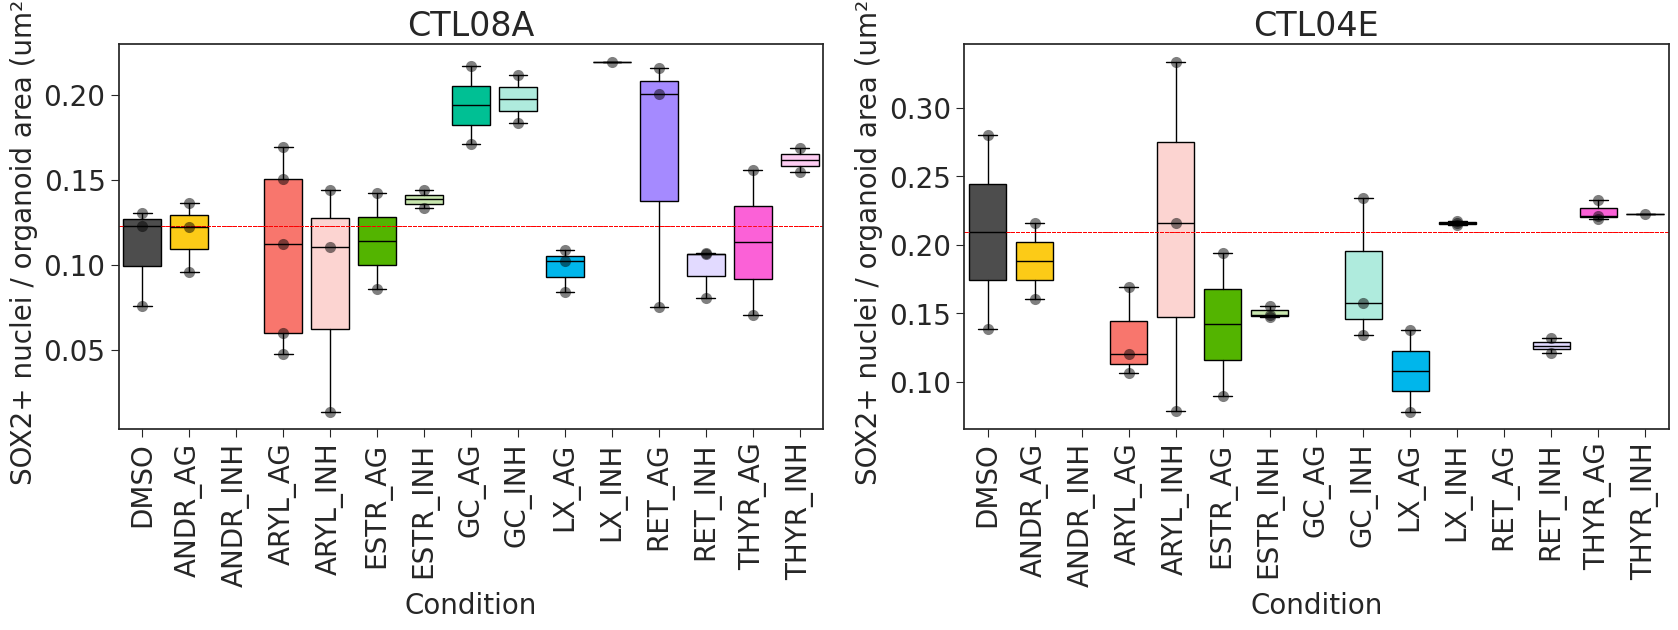

In [391]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for i, cond in enumerate(hormonal_conditions):
    data = density_SOX2[(density_SOX2['Line'] == 'CTL08A') & 
                                 (density_SOX2['Condition'] == cond)]['otsu_1']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = density_SOX2[(density_SOX2['Condition'] == 'DMSO') & 
                                       (density_SOX2['Line'] == 'CTL08A')]['otsu_1'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=density_SOX2[(density_SOX2['Line'] == 'CTL08A')],
    y='otsu_1', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = density_SOX2[(density_SOX2['Line'] == 'CTL04E') & 
                                 (density_SOX2['Condition'] == cond)]['otsu_1']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = density_SOX2[(density_SOX2['Condition'] == 'DMSO') & 
                                       (density_SOX2['Line'] == 'CTL04E')]['otsu_1'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=density_SOX2[density_SOX2['Line'] == 'CTL04E'],
    y='otsu_1', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('SOX2+ nuclei / organoid area (um²)')
ax[1].set_ylabel('SOX2+ nuclei / organoid area (um²)')

plt.savefig('../../endpoints_figures/SOX2_density_otsu_1_per_condition.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/SOX2_density_otsu_1_per_condition.png', dpi=300, bbox_inches='tight')

In [392]:
density_SOX2[density_SOX2.Condition.isin(['RET_AG', 'DMSO'])][['otsu_1', 'Condition']].sort_values(by='Condition', ascending=False).groupby('Condition').median()

,otsu_1
Condition,
DMSO,0.130543
RET_AG,0.200523


## Channel 0 - TUJ1

In [393]:
mask_file_df_mix_1 = mask_file_df_mix_1.merge(sample_sheet, left_on='ImageName_ScanRegion', right_on='ImageName_ScanRegion', how='left')
mask_file_df_mix_1

,level_0,level_1,area,label,intensity_mean,intensity_min,intensity_max,OriginalImageName,ImageName_ScanRegion,ImageName_ScanRegion_Rep,Path,Scan Area,Condition,Line,OPA,Paraffin Block ID,MIX,ImageName,Condition_Line
0,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0134_ScanRegion0_rep_0_c...,41353242.0,1,2417.670006,1451.0,24120.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion0,20240424_manuel_lessi_0134_ScanRegion0_rep_0,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion0,RET_INH,CTL04E,18.0,65.0,1.0,20240424_manuel_lessi_0134,RET_INH_CTL04E
1,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0134_ScanRegion0_rep_1_c...,16657221.0,1,3091.305189,1683.0,18027.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion0,20240424_manuel_lessi_0134_ScanRegion0_rep_1,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion0,RET_INH,CTL04E,18.0,65.0,1.0,20240424_manuel_lessi_0134,RET_INH_CTL04E
2,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0134_ScanRegion0_rep_2_c...,44113333.0,1,3377.073590,1493.0,27952.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion0,20240424_manuel_lessi_0134_ScanRegion0_rep_2,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion0,RET_INH,CTL04E,18.0,65.0,1.0,20240424_manuel_lessi_0134,RET_INH_CTL04E
3,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0134_ScanRegion1_rep_0_c...,10098868.0,1,2645.539375,1110.0,27468.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion1,20240424_manuel_lessi_0134_ScanRegion1_rep_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0134_ScanRegion1_rep_1_c...,7030992.0,1,3937.014572,1941.0,25144.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion1,20240424_manuel_lessi_0134_ScanRegion1_rep_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0128_ScanRegion4_rep_0_c...,31563732.0,1,5826.471794,2338.0,65535.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion4,20240424_manuel_lessi_0128_ScanRegion4_rep_0,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion4,ESTR_INH,CTL08A,12.0,32.0,1.0,20240424_manuel_lessi_0128,ESTR_INH_CTL08A
111,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0128_ScanRegion4_rep_1_c...,15937774.0,1,4450.546162,1907.0,34600.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion4,20240424_manuel_lessi_0128_ScanRegion4_rep_1,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion4,ESTR_INH,CTL08A,12.0,32.0,1.0,20240424_manuel_lessi_0128,ESTR_INH_CTL08A
112,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0128_ScanRegion5_rep_0_c...,27625720.0,1,8458.966141,3148.0,65535.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion5,20240424_manuel_lessi_0128_ScanRegion5_rep_0,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion5,ANDR_AG,CTL08A,12.0,34.0,1.0,20240424_manuel_lessi_0128,ANDR_AG_CTL08A
113,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0128_ScanRegion5_rep_1_c...,24213189.0,1,8076.440269,3291.0,64452.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion5,20240424_manuel_lessi_0128_ScanRegion5_rep_1,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion5,ANDR_AG,CTL08A,12.0,34.0,1.0,20240424_manuel_lessi_0128,ANDR_AG_CTL08A


In [394]:
mask_file_df_mix_1.set_index('level_1', inplace=True)

In [395]:
mask_file_df_mix_1['Line'] = mask_file_df_mix_1['Condition_Line'].apply(lambda x: x.split('_')[-1] if pd.notnull(x) else x)

In [396]:
mask_file_df_mix_1['organoid_area'] = mask_file_df_mix_1['ImageName_ScanRegion_Rep'].map({i:j for i, j in zip(organoid_areas.index, organoid_areas['area'])})

In [397]:
mask_file_df_mix_1['organoid_area_um2'] = mask_file_df_mix_1['organoid_area'] * (px_size ** 2)
mask_file_df_mix_1['area_um2'] = mask_file_df_mix_1['area'] * (px_size ** 2)

In [398]:
n_nuclei = pd.read_csv('../tables/n_nuclei_mix1.csv')
n_nuclei['ImageName'] = n_nuclei['ImageName'].str.replace('_channel_1', '')

In [399]:
mask_file_df_mix_1['n_nuclei'] = mask_file_df_mix_1['ImageName_ScanRegion_Rep'].map({i:j for i, j in zip(n_nuclei['ImageName'], n_nuclei['count'])})

In [400]:
mask_file_df_mix_1['pos_area_over_nuclei'] = mask_file_df_mix_1['area_um2'] / mask_file_df_mix_1['n_nuclei']
mask_file_df_mix_1['pos_area_over_tot'] = mask_file_df_mix_1['area_um2'] / mask_file_df_mix_1['organoid_area_um2']

In [401]:
mask_file_df_mix_1.to_csv("/group/testa/Project/EndPoints/TPSSU/analysis/measurements_mix_1_ch0_TUJ1.csv")

In [402]:
mask_file_df_mix_1

,level_0,area,label,intensity_mean,intensity_min,intensity_max,OriginalImageName,ImageName_ScanRegion,ImageName_ScanRegion_Rep,Path,...,MIX,ImageName,Condition_Line,Line,organoid_area,organoid_area_um2,area_um2,n_nuclei,pos_area_over_nuclei,pos_area_over_tot
level_1,,,,,,,,,,,,,,,,,,,,,
20240424_manuel_lessi_0134_ScanRegion0_rep_0_channel_0,/group/testa/Project/EndPoints/TPSSU/analysis/...,41353242.0,1,2417.670006,1451.0,24120.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion0,20240424_manuel_lessi_0134_ScanRegion0_rep_0,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,...,1.0,20240424_manuel_lessi_0134,RET_INH_CTL04E,CTL04E,56724590.0,5.991535e+06,4.367936e+06,54097,80.742669,0.729018
20240424_manuel_lessi_0134_ScanRegion0_rep_1_channel_0,/group/testa/Project/EndPoints/TPSSU/analysis/...,16657221.0,1,3091.305189,1683.0,18027.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion0,20240424_manuel_lessi_0134_ScanRegion0_rep_1,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,...,1.0,20240424_manuel_lessi_0134,RET_INH_CTL04E,CTL04E,24401739.0,2.577434e+06,1.759419e+06,24746,71.099126,0.682624
20240424_manuel_lessi_0134_ScanRegion0_rep_2_channel_0,/group/testa/Project/EndPoints/TPSSU/analysis/...,44113333.0,1,3377.073590,1493.0,27952.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion0,20240424_manuel_lessi_0134_ScanRegion0_rep_2,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,...,1.0,20240424_manuel_lessi_0134,RET_INH_CTL04E,CTL04E,55519766.0,5.864275e+06,4.659471e+06,50003,93.183825,0.794552
20240424_manuel_lessi_0134_ScanRegion1_rep_0_channel_0,/group/testa/Project/EndPoints/TPSSU/analysis/...,10098868.0,1,2645.539375,1110.0,27468.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion1,20240424_manuel_lessi_0134_ScanRegion1_rep_0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.066693e+06,12349,86.378892,NaN
20240424_manuel_lessi_0134_ScanRegion1_rep_1_channel_0,/group/testa/Project/EndPoints/TPSSU/analysis/...,7030992.0,1,3937.014572,1941.0,25144.0,20240424_manuel_lessi_0134,20240424_manuel_lessi_0134_ScanRegion1,20240424_manuel_lessi_0134_ScanRegion1_rep_1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.426485e+05,12207,60.837923,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20240424_manuel_lessi_0128_ScanRegion4_rep_0_channel_0,/group/testa/Project/EndPoints/TPSSU/analysis/...,31563732.0,1,5826.471794,2338.0,65535.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion4,20240424_manuel_lessi_0128_ScanRegion4_rep_0,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,...,1.0,20240424_manuel_lessi_0128,ESTR_INH_CTL08A,CTL08A,42198648.0,4.457232e+06,3.333919e+06,42538,78.375081,0.747980
20240424_manuel_lessi_0128_ScanRegion4_rep_1_channel_0,/group/testa/Project/EndPoints/TPSSU/analysis/...,15937774.0,1,4450.546162,1907.0,34600.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion4,20240424_manuel_lessi_0128_ScanRegion4_rep_1,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,...,1.0,20240424_manuel_lessi_0128,ESTR_INH_CTL08A,CTL08A,21487131.0,2.269578e+06,1.683427e+06,17120,98.331038,0.741736
20240424_manuel_lessi_0128_ScanRegion5_rep_0_channel_0,/group/testa/Project/EndPoints/TPSSU/analysis/...,27625720.0,1,8458.966141,3148.0,65535.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion5,20240424_manuel_lessi_0128_ScanRegion5_rep_0,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,...,1.0,20240424_manuel_lessi_0128,ANDR_AG_CTL08A,CTL08A,35064139.0,3.703650e+06,2.917967e+06,36668,79.578016,0.787862


### Plot positive area/number of nuclei

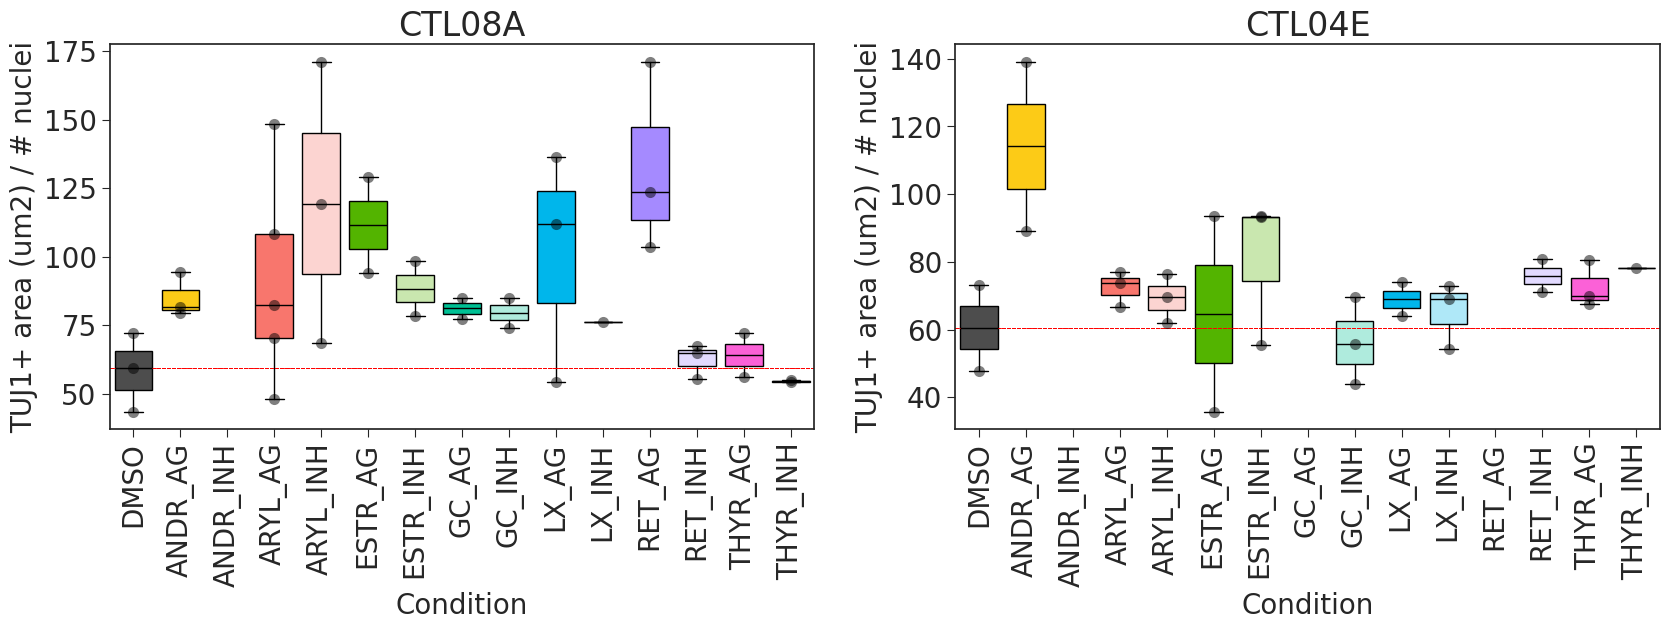

In [403]:
df = mask_file_df_mix_1[mask_file_df_mix_1.ImageName_ScanRegion_Rep.isin(good_tissue_to_keep_limit)]

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for i, cond in enumerate(hormonal_conditions):
    data = df[(df['Line'] == 'CTL08A') & 
                                 (df['Condition'] == cond)]['pos_area_over_nuclei']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = df[(df['Condition'] == 'DMSO') & 
                                       (df['Line'] == 'CTL08A')]['pos_area_over_nuclei'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df[(df['Line'] == 'CTL08A')],
    y='pos_area_over_nuclei', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = df[(df['Line'] == 'CTL04E') & 
                                 (df['Condition'] == cond)]['pos_area_over_nuclei']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = df[(df['Condition'] == 'DMSO') & 
                                       (df['Line'] == 'CTL04E')]['pos_area_over_nuclei'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df[df['Line'] == 'CTL04E'],
    y='pos_area_over_nuclei', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('TUJ1+ area (um2) / # nuclei')
ax[1].set_ylabel('TUJ1+ area (um2) / # nuclei')

plt.savefig('../../endpoints_figures/TUJ1_pos_area_over_nuclei_per_condition.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/TUJ1_pos_area_over_nuclei_per_condition.png', dpi=300, bbox_inches='tight')

In [404]:
df[df.Condition.isin(['RET_AG', 'DMSO'])][['pos_area_over_nuclei', 'Condition']].sort_values(by='Condition', ascending=False).groupby('Condition').median()

,pos_area_over_nuclei
Condition,
DMSO,59.300010
RET_AG,123.506076


### Plot positive area/total area

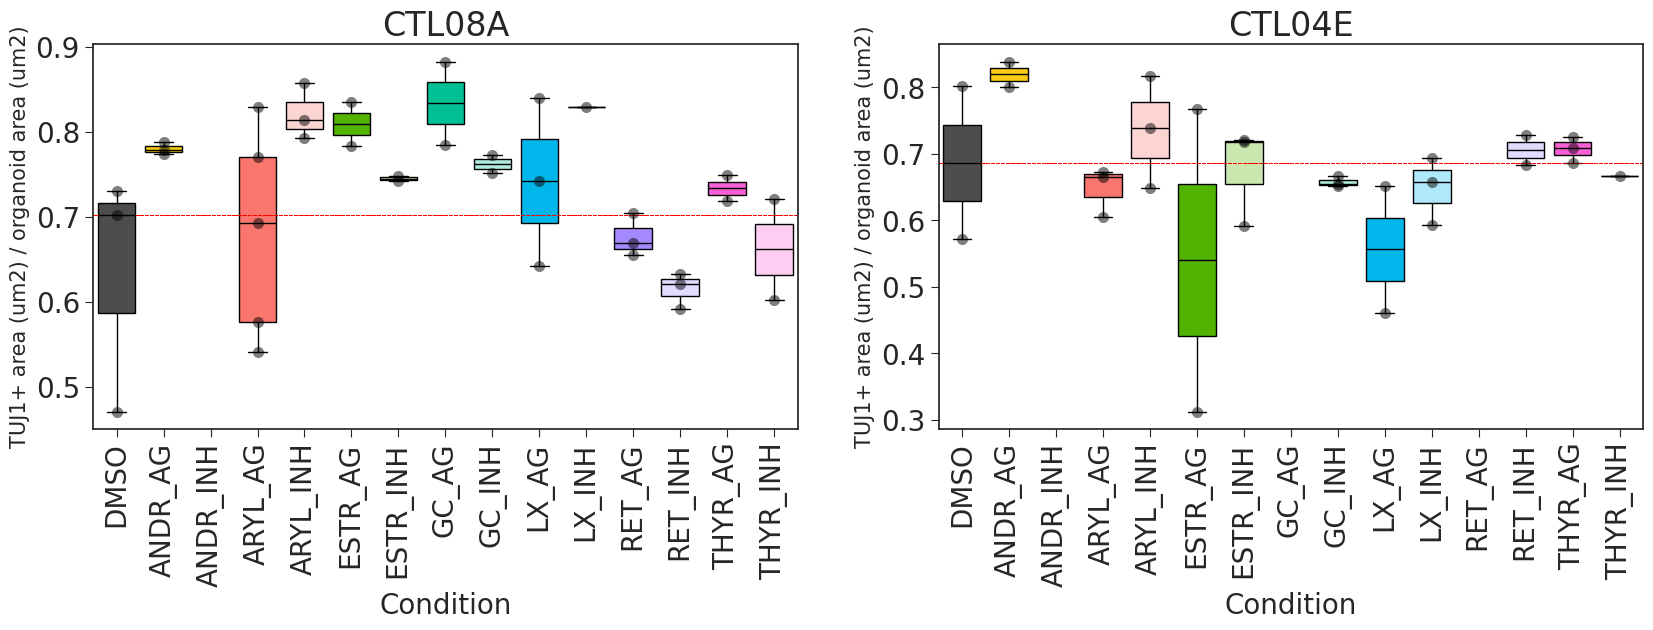

In [405]:
df = mask_file_df_mix_1[mask_file_df_mix_1.ImageName_ScanRegion_Rep.isin(good_tissue_to_keep_limit)]

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for i, cond in enumerate(hormonal_conditions):
    data = df[(df['Line'] == 'CTL08A') & 
                                 (df['Condition'] == cond)]['pos_area_over_tot']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = df[(df['Condition'] == 'DMSO') & 
                                       (df['Line'] == 'CTL08A')]['pos_area_over_tot'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df[(df['Line'] == 'CTL08A')],
    y='pos_area_over_tot', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = df[(df['Line'] == 'CTL04E') & 
                                 (df['Condition'] == cond)]['pos_area_over_tot']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = df[(df['Condition'] == 'DMSO') & 
                                       (df['Line'] == 'CTL04E')]['pos_area_over_tot'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df[df['Line'] == 'CTL04E'],
    y='pos_area_over_tot', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('TUJ1+ area (um2) / organoid area (um2)', fontsize=15)
ax[1].set_ylabel('TUJ1+ area (um2) / organoid area (um2)', fontsize=15)

plt.savefig('../../endpoints_figures/TUJ1_pos_area_over_tot_per_condition.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/TUJ1_pos_area_over_tot_per_condition.png', dpi=300, bbox_inches='tight')

In [406]:
df[df.Condition.isin(['RET_AG', 'DMSO'])][['pos_area_over_tot', 'Condition']].sort_values(by='Condition', ascending=False).groupby('Condition').median()

,pos_area_over_tot
Condition,
DMSO,0.702504
RET_AG,0.669194


## Channel 2 - SOX2 - Area

In [407]:
SOX2_KI67_mask_file_df_mix_1 = SOX2_KI67_mask_file_df_mix_1.merge(sample_sheet, left_on='ImageName_ScanRegion', right_on='ImageName_ScanRegion', how='left')
SOX2_KI67_mask_file_df_mix_1

,level_0,level_1,area,label,intensity_mean,intensity_min,intensity_max,OriginalImageName,ImageName_ScanRegion,ImageName_ScanRegion_Rep,Path,Scan Area,Condition,Line,OPA,Paraffin Block ID,MIX,ImageName,Condition_Line
0,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0133_ScanRegion0_rep_0_c...,21490093.0,1,3839.355973,1168.0,38274.0,20240424_manuel_lessi_0133,20240424_manuel_lessi_0133_ScanRegion0,20240424_manuel_lessi_0133_ScanRegion0_rep_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0133_ScanRegion0_rep_1_c...,14199055.0,1,4477.197476,1226.0,46860.0,20240424_manuel_lessi_0133,20240424_manuel_lessi_0133_ScanRegion0,20240424_manuel_lessi_0133_ScanRegion0_rep_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0133_ScanRegion0_rep_2_c...,15755642.0,1,3759.473544,1092.0,43784.0,20240424_manuel_lessi_0133,20240424_manuel_lessi_0133_ScanRegion0,20240424_manuel_lessi_0133_ScanRegion0_rep_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0133_ScanRegion1_rep_0_c...,1037489.0,1,2031.997964,957.0,21498.0,20240424_manuel_lessi_0133,20240424_manuel_lessi_0133_ScanRegion1,20240424_manuel_lessi_0133_ScanRegion1_rep_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0133_ScanRegion1_rep_1_c...,2023185.0,1,3780.785030,1512.0,38018.0,20240424_manuel_lessi_0133,20240424_manuel_lessi_0133_ScanRegion1,20240424_manuel_lessi_0133_ScanRegion1_rep_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0128_ScanRegion4_rep_0_c...,16244663.0,1,4090.208776,1313.0,48739.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion4,20240424_manuel_lessi_0128_ScanRegion4_rep_0,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion4,ESTR_INH,CTL08A,12.0,32.0,1.0,20240424_manuel_lessi_0128,ESTR_INH_CTL08A
111,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0128_ScanRegion4_rep_1_c...,7057712.0,1,4113.493459,1235.0,42141.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion4,20240424_manuel_lessi_0128_ScanRegion4_rep_1,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion4,ESTR_INH,CTL08A,12.0,32.0,1.0,20240424_manuel_lessi_0128,ESTR_INH_CTL08A
112,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0128_ScanRegion5_rep_0_c...,12963431.0,1,5394.798945,1568.0,44306.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion5,20240424_manuel_lessi_0128_ScanRegion5_rep_0,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion5,ANDR_AG,CTL08A,12.0,34.0,1.0,20240424_manuel_lessi_0128,ANDR_AG_CTL08A
113,/group/testa/Project/EndPoints/TPSSU/analysis/...,20240424_manuel_lessi_0128_ScanRegion5_rep_1_c...,10831979.0,1,4610.981995,1604.0,40226.0,20240424_manuel_lessi_0128,20240424_manuel_lessi_0128_ScanRegion5,20240424_manuel_lessi_0128_ScanRegion5_rep_1,T:\Project\EndPoints\TPSSU\Pictures\20240424_m...,ScanRegion5,ANDR_AG,CTL08A,12.0,34.0,1.0,20240424_manuel_lessi_0128,ANDR_AG_CTL08A


In [408]:
SOX2_KI67_mask_file_df_mix_1.set_index('level_1', inplace=True)

In [409]:
SOX2_KI67_mask_file_df_mix_1['Line'] = SOX2_KI67_mask_file_df_mix_1['Condition_Line'].apply(lambda x: x.split('_')[-1] if pd.notnull(x) else x)

In [410]:
SOX2_KI67_mask_file_df_mix_1['organoid_area_um2'] = SOX2_KI67_mask_file_df_mix_1['ImageName_ScanRegion_Rep'].map({i:j for i, j in zip(organoid_areas.index, organoid_areas['area'])}) * (px_size ** 2)
SOX2_KI67_mask_file_df_mix_1['area_um2'] = SOX2_KI67_mask_file_df_mix_1['area'] * (px_size ** 2)

In [411]:
SOX2_KI67_mask_file_df_mix_1['n_nuclei'] = SOX2_KI67_mask_file_df_mix_1['ImageName_ScanRegion_Rep'].map({i:j for i, j in zip(n_nuclei['ImageName'], n_nuclei['count'])})

In [412]:
SOX2_KI67_mask_file_df_mix_1['pos_area_over_nuclei'] = SOX2_KI67_mask_file_df_mix_1['area_um2'] / SOX2_KI67_mask_file_df_mix_1['n_nuclei']
SOX2_KI67_mask_file_df_mix_1['pos_area_over_tot'] = SOX2_KI67_mask_file_df_mix_1['area_um2'] / SOX2_KI67_mask_file_df_mix_1['organoid_area_um2']

In [413]:
mask_file_df_mix_1.to_csv("/group/testa/Project/EndPoints/TPSSU/analysis/measurements_mix_1_ch0_TUJ1.csv")

### Plot positive area/number of nuclei

Text(0, 0.5, 'SOX2+ area (um2) / # nuclei')

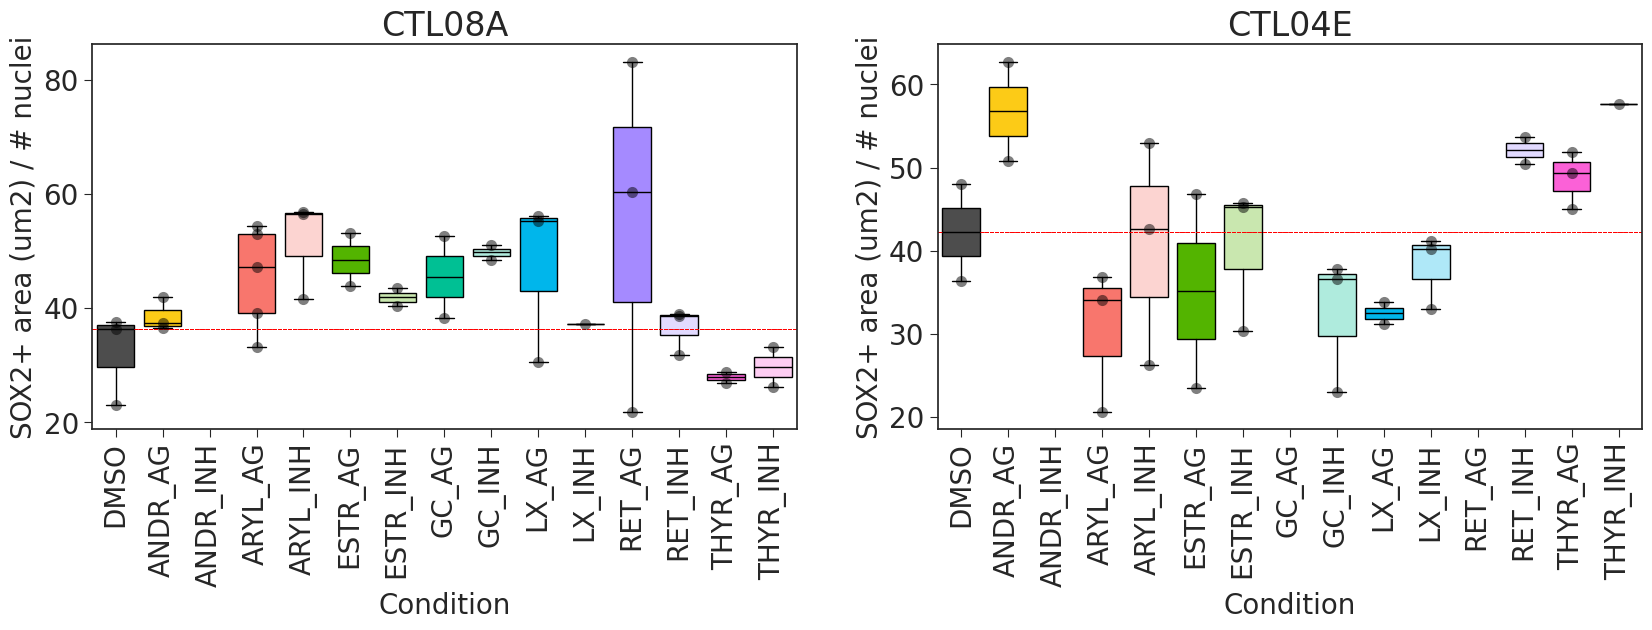

In [414]:
df = SOX2_KI67_mask_file_df_mix_1[SOX2_KI67_mask_file_df_mix_1.ImageName_ScanRegion_Rep.isin(good_tissue_to_keep_limit)]

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for i, cond in enumerate(hormonal_conditions):
    data = df[(df['Line'] == 'CTL08A') & 
                                 (df['Condition'] == cond)]['pos_area_over_nuclei']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = df[(df['Condition'] == 'DMSO') & 
                                       (df['Line'] == 'CTL08A')]['pos_area_over_nuclei'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df[(df['Line'] == 'CTL08A')],
    y='pos_area_over_nuclei', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = df[(df['Line'] == 'CTL04E') & 
                                 (df['Condition'] == cond)]['pos_area_over_nuclei']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = df[(df['Condition'] == 'DMSO') & 
                                       (df['Line'] == 'CTL04E')]['pos_area_over_nuclei'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df[df['Line'] == 'CTL04E'],
    y='pos_area_over_nuclei', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('SOX2+ area (um2) / # nuclei')
ax[1].set_ylabel('SOX2+ area (um2) / # nuclei')

In [415]:
df[df.Condition.isin(['RET_AG', 'DMSO'])][['pos_area_over_nuclei', 'Condition']].sort_values(by='Condition', ascending=False).groupby('Condition').median()

,pos_area_over_nuclei
Condition,
DMSO,36.427254
RET_AG,60.364566


### Plot positive area/total area

Text(0, 0.5, 'SOX2+ area (um2) / organoid area (um2)')

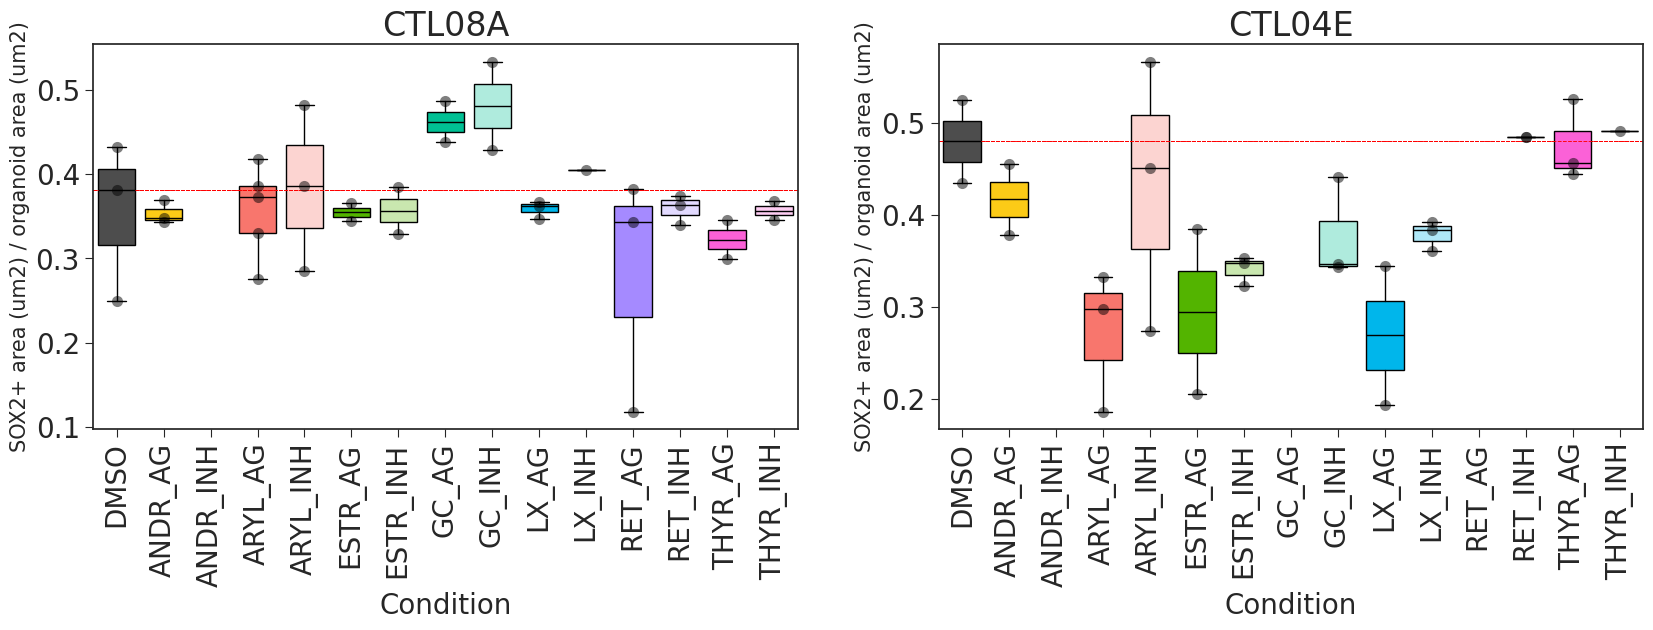

In [416]:
df = SOX2_KI67_mask_file_df_mix_1[SOX2_KI67_mask_file_df_mix_1.ImageName_ScanRegion_Rep.isin(good_tissue_to_keep_limit)]

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for i, cond in enumerate(hormonal_conditions):
    data = df[(df['Line'] == 'CTL08A') & 
                                 (df['Condition'] == cond)]['pos_area_over_tot']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = df[(df['Condition'] == 'DMSO') & 
                                       (df['Line'] == 'CTL08A')]['pos_area_over_tot'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df[(df['Line'] == 'CTL08A')],
    y='pos_area_over_tot', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = df[(df['Line'] == 'CTL04E') & 
                                 (df['Condition'] == cond)]['pos_area_over_tot']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = df[(df['Condition'] == 'DMSO') & 
                                       (df['Line'] == 'CTL04E')]['pos_area_over_tot'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df[df['Line'] == 'CTL04E'],
    y='pos_area_over_tot', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('SOX2+ area (um2) / organoid area (um2)', fontsize=15)
ax[1].set_ylabel('SOX2+ area (um2) / organoid area (um2)', fontsize=15)

In [417]:
df[df.Condition.isin(['RET_AG', 'DMSO'])][['pos_area_over_tot', 'Condition']].sort_values(by='Condition', ascending=False).groupby('Condition').median()

,pos_area_over_tot
Condition,
DMSO,0.431540
RET_AG,0.342605


## SOX2 / TUJ1 ratio

In [418]:
n_nuclei_tot_pos_SOX2_otsu1 = {k: v['otsu_1'] for k, v in n_nuclei_tot_pos_SOX2.items() if 'otsu_1' in v}

In [419]:

df['SOX2+'] = df['ImageName_ScanRegion_Rep'].map(n_nuclei_tot_pos_SOX2_otsu1)

/tmp/ipykernel_1393641/1000197899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SOX2+'] = df['ImageName_ScanRegion_Rep'].map(n_nuclei_tot_pos_SOX2_otsu1)


In [420]:
df["SOX2+_TUJ1_ratio"] = df['SOX2+'] / df['area_um2']

/tmp/ipykernel_1393641/3857021914.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SOX2+_TUJ1_ratio"] = df['SOX2+'] / df['area_um2']


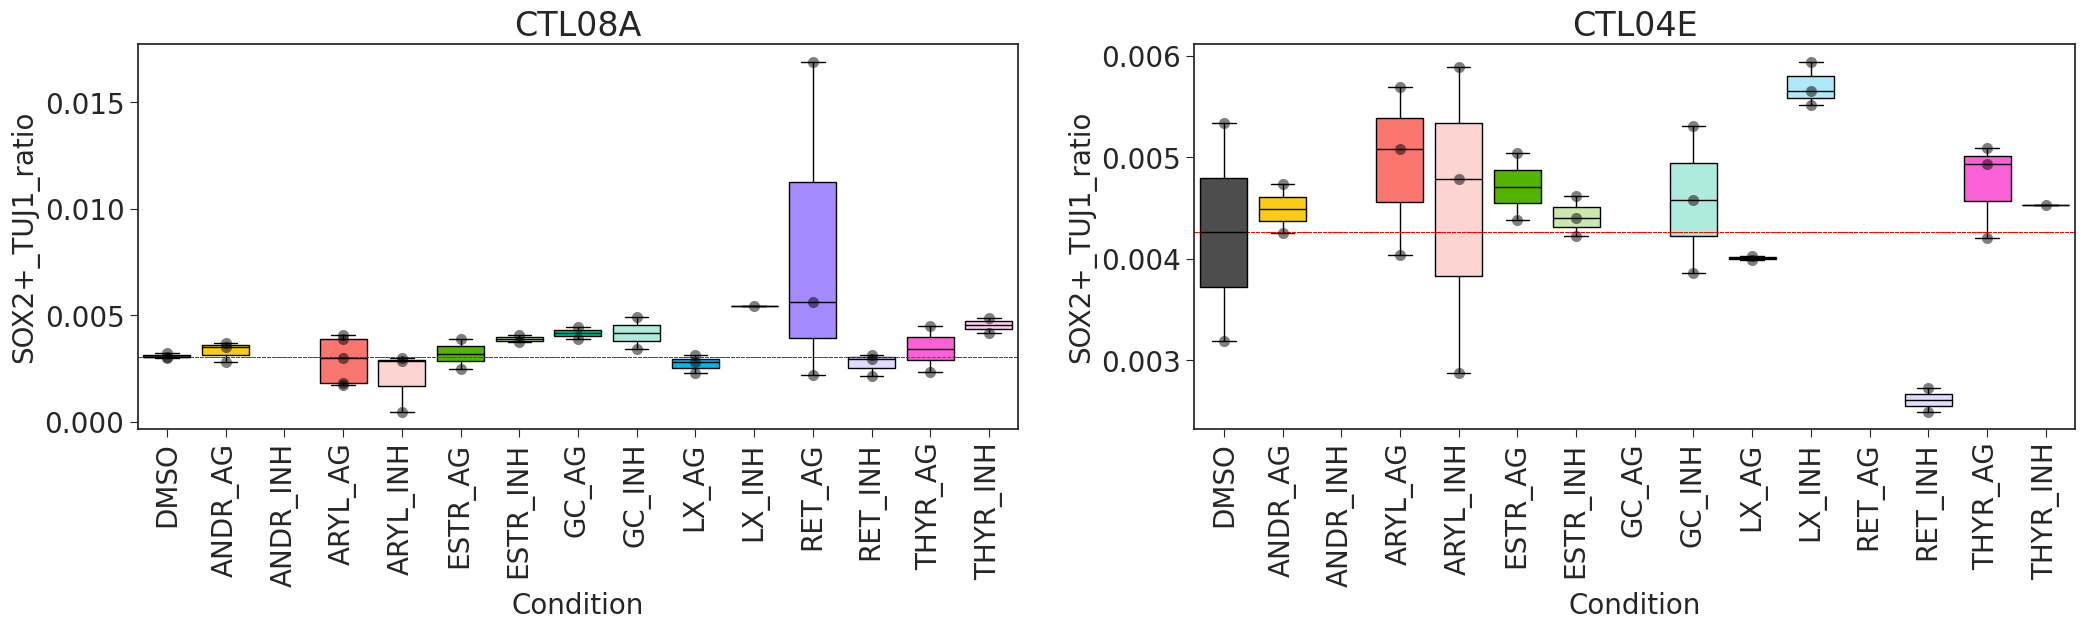

In [421]:

fig, ax = plt.subplots(1, 2, figsize=(25, 5))
for i, cond in enumerate(hormonal_conditions):
    data = df[(df['Line'] == 'CTL08A') & 
                                 (df['Condition'] == cond)]['SOX2+_TUJ1_ratio']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = df[(df['Condition'] == 'DMSO') & 
                                       (df['Line'] == 'CTL08A')]['SOX2+_TUJ1_ratio'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df[(df['Line'] == 'CTL08A')],
    y='SOX2+_TUJ1_ratio', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = df[(df['Line'] == 'CTL04E') & 
                                 (df['Condition'] == cond)]['SOX2+_TUJ1_ratio']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = df[(df['Condition'] == 'DMSO') & 
                                       (df['Line'] == 'CTL04E')]['SOX2+_TUJ1_ratio'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df[df['Line'] == 'CTL04E'],
    y='SOX2+_TUJ1_ratio', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('SOX2+_TUJ1_ratio')
ax[1].set_ylabel('SOX2+_TUJ1_ratio')

plt.savefig('../../endpoints_figures/SOX2+_TUJ1_ratio_per_condition.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/SOX2+_TUJ1_ratio_per_condition.png', dpi=300, bbox_inches='tight')

# MIX 2

## Channel 2 - MKI67

In [422]:
tot_df_mix2_ch2 = pd.DataFrame()
measurements_files_mix_2_ch2 = [f for f in measurements_files_mix_2 if 'channel_2' in f]

for file in measurements_files_mix_2_ch2:
    df = pd.read_csv(file, index_col=0)
    df['ImageName'] = file.split("/")[-1].split(".")[0]
    tot_df_mix2_ch2 = pd.concat([tot_df_mix2_ch2, df], axis=0)


In [423]:
# tot_df_mix2_ch2.to_csv("/group/testa/Project/EndPoints/TPSSU/analysis/measurements_mix_2_ch2_MKI67.csv")

### Thresholding

In [424]:
tot_pos_MKI67 = {}
dens_norm_MKI67 = {}
density_MKI67 = {}
n_nuclei = {}
n_nuclei_tot_pos_MKI67 = {}

for file in measurements_files_mix_2_ch2:
    #print(file)
    imageName_scanRegion_rep = file.split('/')[-1].split('.')[0].replace('_channel_2_measures', '')
    imageName_scanRegion = '_'.join(imageName_scanRegion_rep.split('_')[:5])
    
    if imageName_scanRegion_rep in good_tissue_to_keep_limit and imageName_scanRegion in sample_sheet['ImageName_ScanRegion'].values:
        df = pd.read_csv(file, index_col=0)
        
        imageName_scanRegion_rep = file.split('/')[-1].split('.')[0].replace('_channel_2_measures', '')
        density = density_dict[imageName_scanRegion_rep]
        area = area_dict[imageName_scanRegion_rep]
        
        df['ImageName'] = file.split("/")[-1].split(".")[0]
        tot_pos_MKI67[file.split("/")[-1].split(".")[0]] = {}
        dens_norm_MKI67[imageName_scanRegion_rep] = {}
        density_MKI67[imageName_scanRegion_rep] = {}
        n_nuclei_tot_pos_MKI67[imageName_scanRegion_rep] = {}

        min_quantile = np.quantile(df['area'], 0.01)

        max_quantile = np.quantile(df['area'], 0.99)

        df = df[(df['area'] > min_quantile) & (df['area'] < max_quantile)]

        n_nuclei[file.split("/")[-1].split(".")[0]] = df.shape[0]

        otsu_thrs = filters.threshold_multiotsu(np.array(df['intensity_mean']), classes = 4)

        for i, thr in enumerate(otsu_thrs):
            tot_pos_MKI67[file.split("/")[-1].split(".")[0]][f'otsu_{i}'] = np.sum(df['intensity_mean'] > thr) / df.shape[0] * 100
            n_nuclei_tot_pos_MKI67[imageName_scanRegion_rep][f'otsu_{i}'] = np.sum(df['intensity_mean'] > thr)
            dens_norm_MKI67[imageName_scanRegion_rep][f'otsu_{i}'] = tot_pos_MKI67[file.split("/")[-1].split(".")[0]][f'otsu_{i}'] * density
            density_MKI67[imageName_scanRegion_rep][f'otsu_{i}'] = np.sum(df['intensity_mean'] > thr) / area * 100


In [425]:
df_percentages = pd.DataFrame.from_dict(tot_pos_MKI67, orient='index')
df_percentages['ImageName_ScanRegion'] = df_percentages.reset_index()['index'].apply(lambda x: '_'.join(x.split('_')[0:5])).values
df_percentages['ImageName_ScanRegion_rep'] = df_percentages.reset_index()['index'].apply(lambda x: '_'.join(x.split('_')[0:7])).values
df_percentages['Condition_Line'] = df_percentages['ImageName_ScanRegion'].map(sample_dict)
df_percentages = df_percentages[~df_percentages.Condition_Line.isna()]
df_percentages['Line'] = df_percentages['Condition_Line'].apply(lambda x: x.split('_')[-1])
df_percentages['Condition'] = df_percentages['Condition_Line'].str.replace('_CTL08A', '', regex=True)
df_percentages['Condition'] = df_percentages['Condition'].str.replace('_CTL04E', '', regex=True)

#df_percentages.to_csv("/group/testa/Project/EndPoints/TPSSU/analysis/percentages_mix_2_ch2_MKI67_percentages.csv")

In [426]:
KI67_pos = pd.DataFrame.from_dict(n_nuclei_tot_pos_MKI67, orient='index')
KI67_pos['ImageName_ScanRegion'] = KI67_pos.reset_index()['index'].apply(lambda x: '_'.join(x.split('_')[0:5])).values
KI67_pos['ImageName_ScanRegion_rep'] = KI67_pos.reset_index()['index'].apply(lambda x: '_'.join(x.split('_')[0:7])).values
KI67_pos['Condition_Line'] = KI67_pos['ImageName_ScanRegion'].map(sample_dict)
KI67_pos = KI67_pos[~KI67_pos.Condition_Line.isna()]
KI67_pos['Line'] = KI67_pos['Condition_Line'].apply(lambda x: x.split('_')[-1])
KI67_pos['Condition'] = KI67_pos['Condition_Line'].str.replace('_CTL08A', '', regex=True)
KI67_pos['Condition'] = KI67_pos['Condition'].str.replace('_CTL04E', '', regex=True)

In [427]:
density_MKI67 = pd.DataFrame.from_dict(density_MKI67, orient='index').reset_index()
density_MKI67['ImageName_ScanRegion'] = density_MKI67['index'].apply(lambda x: '_'.join(x.split('_')[0:5]))
density_MKI67['ImageName_ScanRegion_rep'] = density_MKI67['index'].apply(lambda x: '_'.join(x.split('_')[0:7]))
density_MKI67['Condition_Line'] = density_MKI67['ImageName_ScanRegion'].map(sample_dict)
density_MKI67 = density_MKI67[~density_MKI67.Condition_Line.isna()]
density_MKI67['Line'] = density_MKI67['Condition_Line'].apply(lambda x: x.split('_')[-1])
density_MKI67['Condition'] = density_MKI67['Condition_Line'].str.replace('_CTL08A', '', regex=True)
density_MKI67['Condition'] = density_MKI67['Condition'].str.replace('_CTL04E', '', regex=True)

print(len(density_MKI67))
#density_MKI67.to_csv("/group/testa/Project/EndPoints/TPSSU/analysis/MKI67_pos_over_area_mix_1_ch2.csv")

74


In [428]:
n_nuclei_df = pd.DataFrame.from_dict(n_nuclei, orient='index').reset_index()
n_nuclei_df['ImageName_ScanRegion'] = n_nuclei_df['index'].apply(lambda x: '_'.join(x.split('_')[0:5]))
n_nuclei_df['ImageName_ScanRegion_rep'] = n_nuclei_df['index'].apply(lambda x: '_'.join(x.split('_')[0:7]))
n_nuclei_df['Condition_Line'] = n_nuclei_df['ImageName_ScanRegion'].map(sample_dict)
n_nuclei_df = n_nuclei_df[~n_nuclei_df.Condition_Line.isna()]
n_nuclei_df['Line'] = n_nuclei_df['Condition_Line'].apply(lambda x: x.split('_')[-1])
n_nuclei_df['Condition'] = n_nuclei_df['Condition_Line'].str.replace('_CTL08A', '', regex=True)
n_nuclei_df['Condition'] = n_nuclei_df['Condition'].str.replace('_CTL04E', '', regex=True)


In [429]:
check_area_df = organoid_areas.loc[KI67_pos.ImageName_ScanRegion_rep.tolist()]
check_area_df

,area,ImageName_ScanRegion,Condition_Line,Line,Condition,Area_um2,n_nuclei,density
20240424_manuel_lessi_0142_ScanRegion2_rep_0,8024395,20240424_manuel_lessi_0142_ScanRegion2,RET_AG_CTL08A,CTL08A,RET_AG,8.475767e+05,2437,0.002875
20240424_manuel_lessi_0142_ScanRegion2_rep_2,9480571,20240424_manuel_lessi_0142_ScanRegion2,RET_AG_CTL08A,CTL08A,RET_AG,1.001385e+06,2340,0.002337
20240424_manuel_lessi_0138_ScanRegion1_rep_2,37281437,20240424_manuel_lessi_0138_ScanRegion1,ANDR_INH_CTL04E,CTL04E,ANDR_INH,3.937852e+06,30867,0.007839
20240424_manuel_lessi_0140_ScanRegion4_rep_1,55908114,20240424_manuel_lessi_0140_ScanRegion4,THYR_INH_CTL08A,CTL08A,THYR_INH,5.905295e+06,72472,0.012272
20240424_manuel_lessi_0140_ScanRegion5_rep_2,41670728,20240424_manuel_lessi_0140_ScanRegion5,THYR_AG_CTL08A,CTL08A,THYR_AG,4.401471e+06,58972,0.013398
...,...,...,...,...,...,...,...,...
20240424_manuel_lessi_0141_ScanRegion3_rep_1,8113209,20240424_manuel_lessi_0141_ScanRegion3,DMSO_CTL04E,CTL04E,DMSO,8.569577e+05,9105,0.010625
20240424_manuel_lessi_0138_ScanRegion5_rep_1,60950304,20240424_manuel_lessi_0138_ScanRegion5,ARYL_AG_CTL04E,CTL04E,ARYL_AG,6.437876e+06,63198,0.009817
20240424_manuel_lessi_0138_ScanRegion3_rep_1,16957648,20240424_manuel_lessi_0138_ScanRegion3,ARYL_AG_CTL08A,CTL08A,ARYL_AG,1.791152e+06,15879,0.008865
20240424_manuel_lessi_0138_ScanRegion1_rep_0,28072509,20240424_manuel_lessi_0138_ScanRegion1,ANDR_INH_CTL04E,CTL04E,ANDR_INH,2.965159e+06,26167,0.008825


In [430]:
check_area_df[check_area_df.Condition.isin(['RET_AG', 'DMSO'])][['area', 'Condition']].sort_values(by='Condition', ascending=False).groupby('Condition').median()

,area
Condition,
DMSO,50055339.0
RET_AG,9480571.0


### Plots
#### Percentages

In [431]:
mix2_img_names = tot_df_mix2_ch2['ImageName'].apply(lambda x: '_'.join(x.split('_')[0:4])).value_counts().index.tolist()
mix2_img_names

['20240424_manuel_lessi_0141',
 '20240424_manuel_lessi_0143',
 '20240424_manuel_lessi_0140',
 '20240424_manuel_lessi_0138',
 '20240424_manuel_lessi_0137',
 '20240424_manuel_lessi_0139',
 '20240424_manuel_lessi_0142']

In [432]:
check_qc_ch2['ImageName_ScanRegion'] = check_qc_ch2['Reference Image Report'].apply(lambda x: '_'.join(x.split('_')[0:5]))
check_qc_ch2['ImageName_ScanRegion_Rep'] = check_qc_ch2['Reference Image Report'].apply(lambda x: '_'.join(x.split('_')[0:7]))
check_qc_ch2['ImageName'] = check_qc_ch2['Reference Image Report'].apply(lambda x: '_'.join(x.split('_')[0:4]))
check_qc_ch2_mix2 = check_qc_ch2[check_qc_ch2['ImageName'].isin(mix2_img_names)]
check_qc_ch2_mix2

,Reference Image Report,general QC (keep or not),ImageName_ScanRegion_Rep,ImageName_ScanRegion,ImageName_ScanRegion_rep,ImageName
131,20240424_manuel_lessi_0137_ScanRegion0_rep_0_c...,LIMIT,20240424_manuel_lessi_0137_ScanRegion0_rep_0,20240424_manuel_lessi_0137_ScanRegion0,20240424_manuel_lessi_0137_ScanRegion0_rep_0,20240424_manuel_lessi_0137
132,20240424_manuel_lessi_0137_ScanRegion1_rep_0_c...,NO,20240424_manuel_lessi_0137_ScanRegion1_rep_0,20240424_manuel_lessi_0137_ScanRegion1,20240424_manuel_lessi_0137_ScanRegion1_rep_0,20240424_manuel_lessi_0137
133,20240424_manuel_lessi_0137_ScanRegion1_rep_1_c...,YES,20240424_manuel_lessi_0137_ScanRegion1_rep_1,20240424_manuel_lessi_0137_ScanRegion1,20240424_manuel_lessi_0137_ScanRegion1_rep_1,20240424_manuel_lessi_0137
134,20240424_manuel_lessi_0137_ScanRegion1_rep_2_c...,NO,20240424_manuel_lessi_0137_ScanRegion1_rep_2,20240424_manuel_lessi_0137_ScanRegion1,20240424_manuel_lessi_0137_ScanRegion1_rep_2,20240424_manuel_lessi_0137
135,20240424_manuel_lessi_0137_ScanRegion2_rep_0_c...,YES,20240424_manuel_lessi_0137_ScanRegion2_rep_0,20240424_manuel_lessi_0137_ScanRegion2,20240424_manuel_lessi_0137_ScanRegion2_rep_0,20240424_manuel_lessi_0137
...,...,...,...,...,...,...
235,20240424_manuel_lessi_0143_ScanRegion4_rep_1_c...,YES,20240424_manuel_lessi_0143_ScanRegion4_rep_1,20240424_manuel_lessi_0143_ScanRegion4,20240424_manuel_lessi_0143_ScanRegion4_rep_1,20240424_manuel_lessi_0143
236,20240424_manuel_lessi_0143_ScanRegion4_rep_2_c...,YES,20240424_manuel_lessi_0143_ScanRegion4_rep_2,20240424_manuel_lessi_0143_ScanRegion4,20240424_manuel_lessi_0143_ScanRegion4_rep_2,20240424_manuel_lessi_0143
237,20240424_manuel_lessi_0143_ScanRegion5_rep_0_c...,YES,20240424_manuel_lessi_0143_ScanRegion5_rep_0,20240424_manuel_lessi_0143_ScanRegion5,20240424_manuel_lessi_0143_ScanRegion5_rep_0,20240424_manuel_lessi_0143
238,20240424_manuel_lessi_0143_ScanRegion5_rep_1_c...,YES,20240424_manuel_lessi_0143_ScanRegion5_rep_1,20240424_manuel_lessi_0143_ScanRegion5,20240424_manuel_lessi_0143_ScanRegion5_rep_1,20240424_manuel_lessi_0143


In [433]:
check_qc_ch2_mix2['general QC (keep or not)'].value_counts()

general QC (keep or not)
YES      60
NO       35
LIMIT    14
Name: count, dtype: int64

In [434]:
to_remove = check_qc_ch2_mix2[check_qc_ch2_mix2['general QC (keep or not)'] == 'NO']['ImageName_ScanRegion_Rep'].tolist()
len(to_remove)

35

In [435]:
df_percentages = df_percentages[~df_percentages['ImageName_ScanRegion_rep'].isin(to_remove)]
len(df_percentages)

49

In [436]:
KI67_pos = KI67_pos[~KI67_pos['ImageName_ScanRegion_rep'].isin(to_remove)]
len(KI67_pos)

49

In [437]:
n_nuclei_df = n_nuclei_df[~n_nuclei_df['ImageName_ScanRegion_rep'].isin(to_remove)]
len(n_nuclei_df)

49

In [438]:
order = df_percentages['Condition'].tolist()
order = list(dict.fromkeys(order))  # Remove duplicates while preserving order
order.remove('DMSO')
order.sort()
order = ['DMSO'] + order

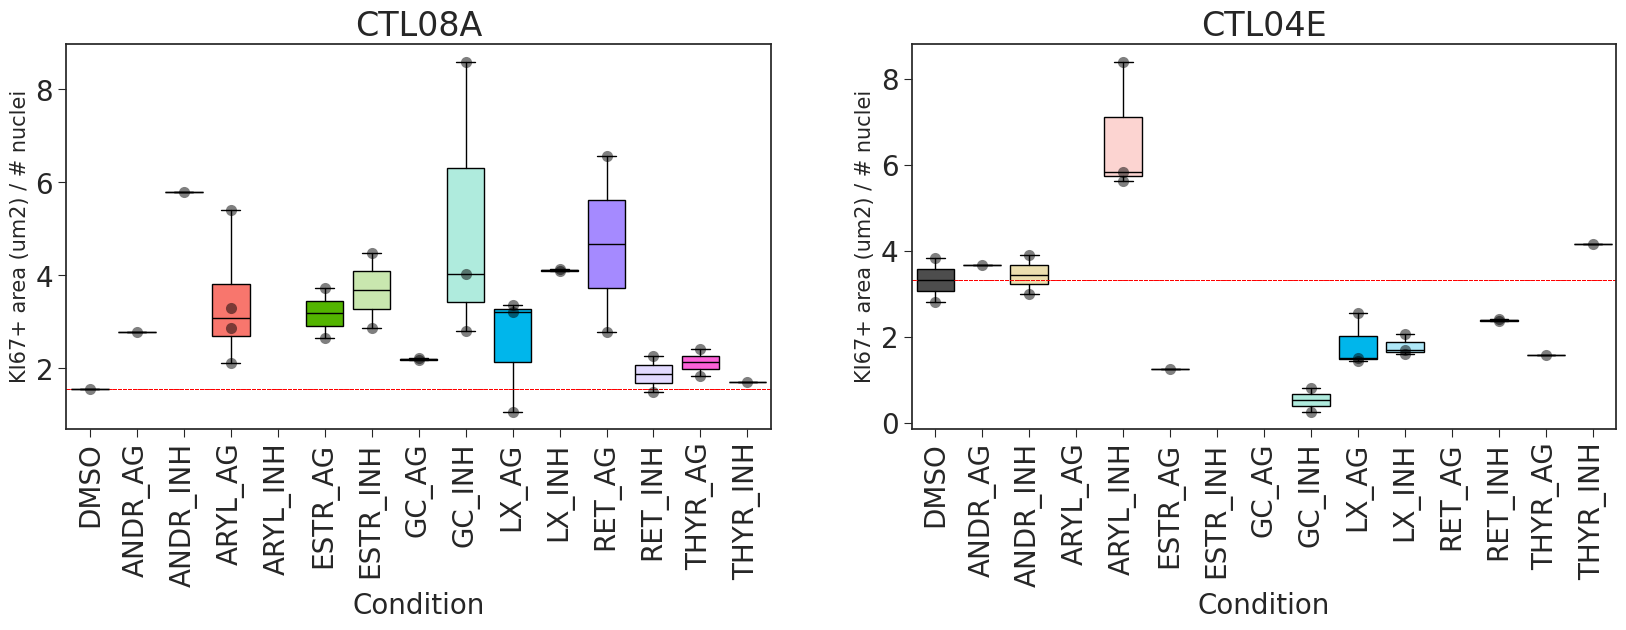

In [439]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for i, cond in enumerate(hormonal_conditions):
    data = df_percentages[(df_percentages['Line'] == 'CTL08A') & 
                                 (df_percentages['Condition'] == cond)]['otsu_1']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = df_percentages[(df_percentages['Condition'] == 'DMSO') & 
                                       (df_percentages['Line'] == 'CTL08A')]['otsu_1'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df_percentages[(df_percentages['Line'] == 'CTL08A')],
    y='otsu_1', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = df_percentages[(df_percentages['Line'] == 'CTL04E') & 
                                 (df_percentages['Condition'] == cond)]['otsu_1']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = df_percentages[(df_percentages['Condition'] == 'DMSO') & 
                                       (df_percentages['Line'] == 'CTL04E')]['otsu_1'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df_percentages[df_percentages['Line'] == 'CTL04E'],
    y='otsu_1', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('KI67+ area (um2) / # nuclei', fontsize=15)
ax[1].set_ylabel('KI67+ area (um2) / # nuclei', fontsize=15)

plt.savefig('../../endpoints_figures/MKI67_pos_per_condition.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/MKI67_pos_per_condition.png', dpi=300, bbox_inches='tight')

In [440]:
df_percentages[df_percentages.Condition.isin(['RET_AG', 'DMSO'])][['otsu_1', 'Condition']].sort_values(by='Condition', ascending=False).groupby('Condition').median()

,otsu_1
Condition,
DMSO,2.812748
RET_AG,4.684807


In [441]:
KI67_pos[KI67_pos.Condition.isin(['RET_AG', 'DMSO'])][['otsu_1', 'Condition']].sort_values(by='Condition', ascending=False).groupby('Condition').median()

,otsu_1
Condition,
DMSO,660.0
RET_AG,110.5


In [442]:
n_nuclei_df[n_nuclei_df.Condition.isin(['RET_AG', 'DMSO'])][[0, 'Condition']].sort_values(by='Condition', ascending=False).groupby('Condition').median()

,0
Condition,
DMSO,42327.0
RET_AG,2339.5


#### MKI67+ / organoid area

In [443]:
df = density_MKI67[density_MKI67.ImageName_ScanRegion_rep.isin(good_tissue_to_keep_limit)]
df = df[~df['ImageName_ScanRegion_rep'].isin(to_remove)]

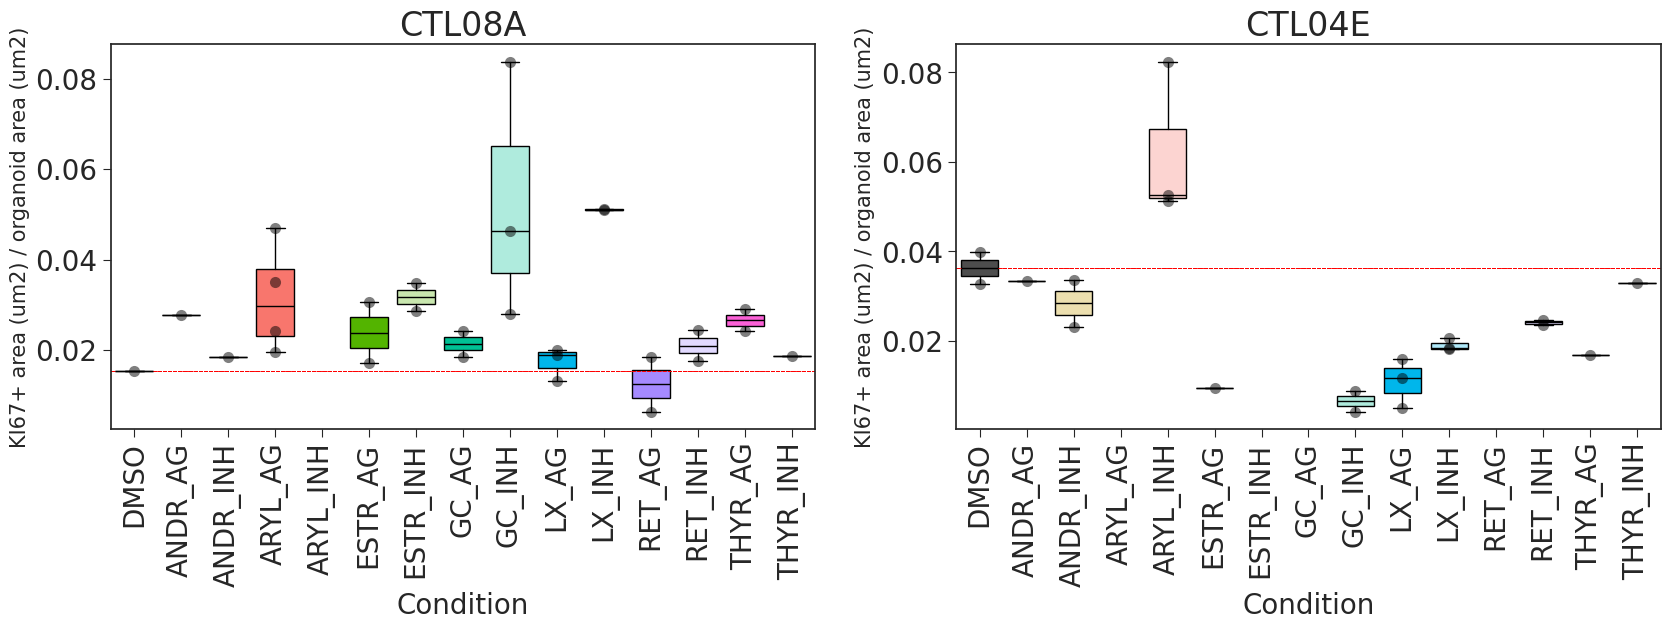

In [444]:

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for i, cond in enumerate(hormonal_conditions):
    data = df[(df['Line'] == 'CTL08A') & 
                                 (df['Condition'] == cond)]['otsu_1']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = df[(df['Condition'] == 'DMSO') & 
                                       (df['Line'] == 'CTL08A')]['otsu_1'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df[(df['Line'] == 'CTL08A')],
    y='otsu_1', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = df[(df['Line'] == 'CTL04E') & 
                                 (df['Condition'] == cond)]['otsu_1']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = df[(df['Condition'] == 'DMSO') & 
                                       (df['Line'] == 'CTL04E')]['otsu_1'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df[df['Line'] == 'CTL04E'],
    y='otsu_1', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('KI67+ area (um2) / organoid area (um2)', fontsize=15)
ax[1].set_ylabel('KI67+ area (um2) / organoid area (um2)', fontsize=15)

plt.savefig('../../endpoints_figures/MKI67_density_per_condition.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/MKI67_density_per_condition.png', dpi=300, bbox_inches='tight')

In [445]:
df[df.Condition.isin(['RET_AG', 'DMSO'])][['otsu_1', 'Condition']].sort_values(by='Condition', ascending=False).groupby('Condition').median()

,otsu_1
Condition,
DMSO,0.032720
RET_AG,0.012457


## Channel 0 - MAP2

In [446]:
mask_file_df_mix_2 = mask_file_df_mix_2.merge(sample_sheet, left_on='ImageName_ScanRegion', right_on='ImageName_ScanRegion', how='left')

In [447]:
#n_nuclei.reset_index(inplace=True)
#n_nuclei.rename(columns={'index': 'ImageName'}, inplace=True)
n_nuclei = {i.replace('_channel_2_measures', ''):j for i, j in zip(n_nuclei.keys(), n_nuclei.values())}

In [448]:
mask_file_df_mix_2['organoid_area_um2'] = mask_file_df_mix_2['ImageName_ScanRegion_Rep'].map({i:j for i, j in zip(organoid_areas.index, organoid_areas['area'])}) * (px_size ** 2)
mask_file_df_mix_2.set_index('ImageName_ScanRegion_Rep', inplace=True)
mask_file_df_mix_2['n_nuclei'] = n_nuclei
mask_file_df_mix_2['area_um2'] = mask_file_df_mix_2['area'] * (px_size ** 2)


In [449]:
mask_file_df_mix_2['pos_area_over_n_nuclei'] = mask_file_df_mix_2['area_um2'] / mask_file_df_mix_2['n_nuclei']
mask_file_df_mix_2['pos_area_over_tot'] = mask_file_df_mix_2['area_um2'] / mask_file_df_mix_2['organoid_area_um2']

In [450]:
mask_file_df_mix_2['Line'] = mask_file_df_mix_2['Condition_Line'].apply(lambda x: x.split('_')[-1] if pd.notnull(x) else x)

In [451]:
#mask_file_df_mix_2.to_csv("/group/testa/Project/EndPoints/TPSSU/analysis/measurements_mix_2_ch0_MAP2.csv")

### Plot positive area/number of nuclei

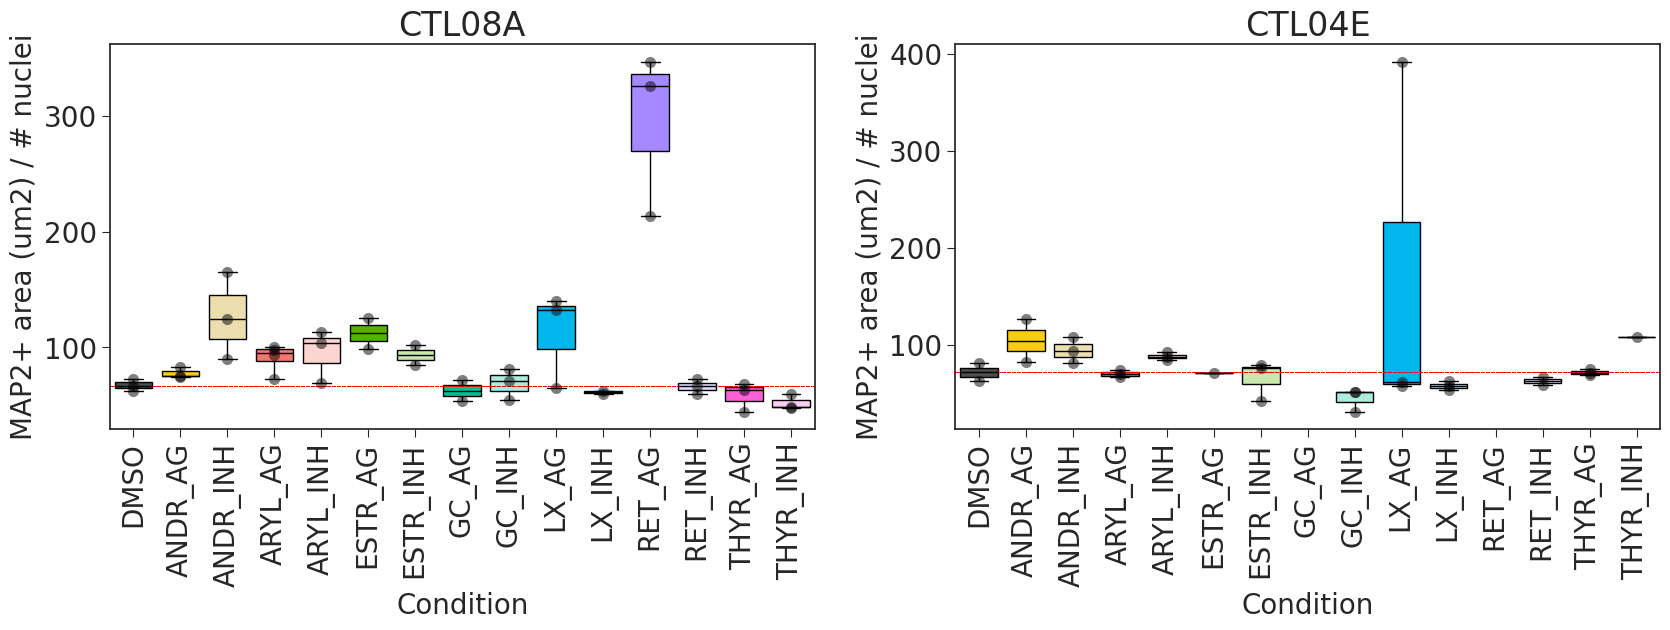

In [452]:
df = mask_file_df_mix_2.loc[[i for i in good_tissue_to_keep_limit if i in mask_file_df_mix_2.index]]
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for i, cond in enumerate(hormonal_conditions):
    data = df[(df['Line'] == 'CTL08A') & 
                                 (df['Condition'] == cond)]['pos_area_over_n_nuclei']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = df[(df['Condition'] == 'DMSO') & 
                                       (df['Line'] == 'CTL08A')]['pos_area_over_n_nuclei'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df[(df['Line'] == 'CTL08A')],
    y='pos_area_over_n_nuclei', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = df[(df['Line'] == 'CTL04E') & 
                                 (df['Condition'] == cond)]['pos_area_over_n_nuclei']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = df[(df['Condition'] == 'DMSO') & 
                                       (df['Line'] == 'CTL04E')]['pos_area_over_n_nuclei'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df[df['Line'] == 'CTL04E'],
    y='pos_area_over_n_nuclei', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('MAP2+ area (um2) / # nuclei')
ax[1].set_ylabel('MAP2+ area (um2) / # nuclei')

plt.savefig('../../endpoints_figures/MAP2_pos_area_over_n_nuclei_per_condition.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/MAP2_pos_area_over_n_nuclei_per_condition.png', dpi=300, bbox_inches='tight')

In [453]:
df[df.Condition.isin(['RET_AG', 'DMSO'])][['pos_area_over_n_nuclei', 'Condition']].sort_values(by='Condition', ascending=False).groupby('Condition').median()

,pos_area_over_n_nuclei
Condition,
DMSO,66.925803
RET_AG,325.869393


### Plot positive area/total area

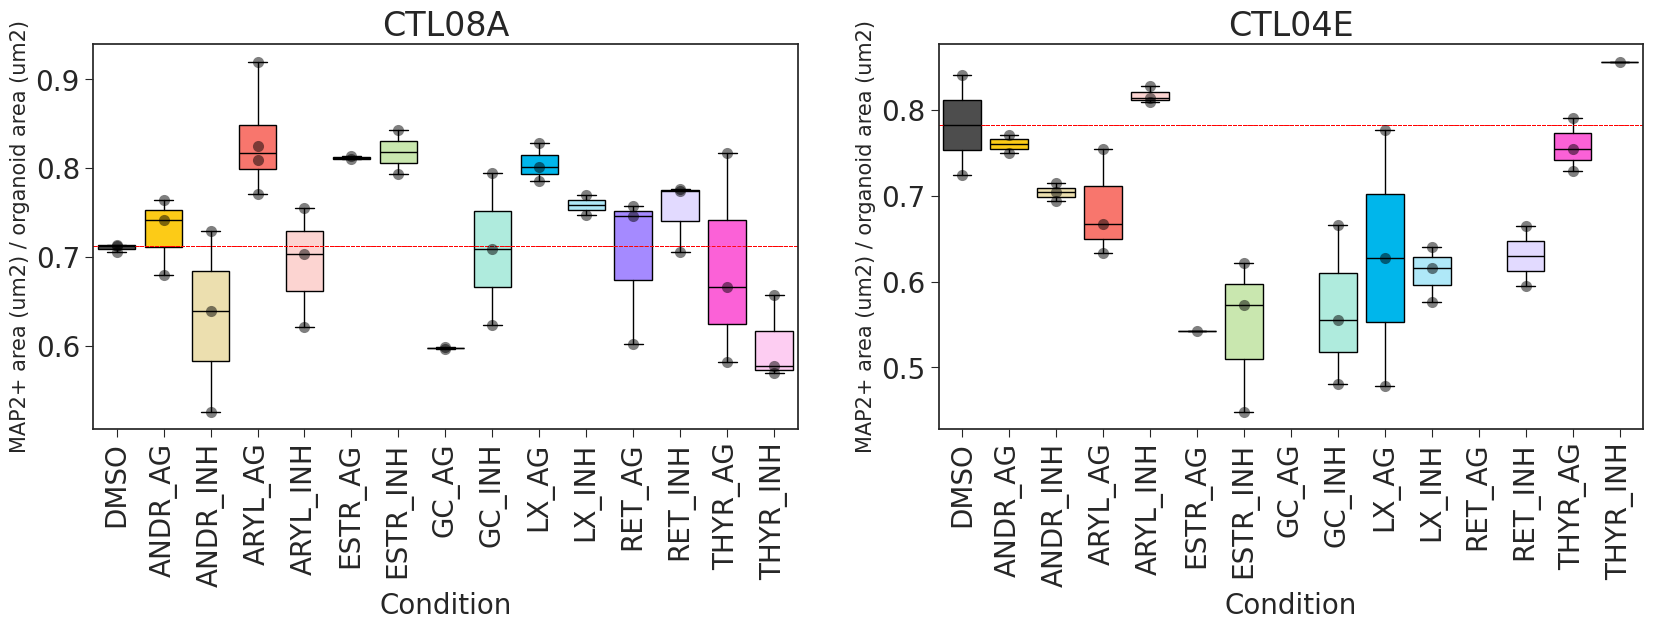

In [454]:
df = mask_file_df_mix_2.loc[[i for i in good_tissue_to_keep_limit if i in mask_file_df_mix_2.index]]
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for i, cond in enumerate(hormonal_conditions):
    data = df[(df['Line'] == 'CTL08A') & 
                                 (df['Condition'] == cond)]['pos_area_over_tot']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = df[(df['Condition'] == 'DMSO') & 
                                       (df['Line'] == 'CTL08A')]['pos_area_over_tot'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df[(df['Line'] == 'CTL08A')],
    y='pos_area_over_tot', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = df[(df['Line'] == 'CTL04E') & 
                                 (df['Condition'] == cond)]['pos_area_over_tot']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = df[(df['Condition'] == 'DMSO') & 
                                       (df['Line'] == 'CTL04E')]['pos_area_over_tot'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df[df['Line'] == 'CTL04E'],
    y='pos_area_over_tot', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('MAP2+ area (um2) / organoid area (um2)', fontsize=15)
ax[1].set_ylabel('MAP2+ area (um2) / organoid area (um2)', fontsize=15)

plt.savefig('../../endpoints_figures/MAP2_pos_area_over_tot_per_condition.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/MAP2_pos_area_over_tot_per_condition.png', dpi=300, bbox_inches='tight')

In [455]:
df[df.Condition.isin(['RET_AG', 'DMSO'])][['pos_area_over_tot', 'Condition']].sort_values(by='Condition', ascending=False).groupby('Condition').median()

,pos_area_over_tot
Condition,
DMSO,0.713576
RET_AG,0.745859


# MKI67 / MAP2 ratio

In [456]:
n_nuclei_tot_pos_MKI67_otsu1 = {k: v['otsu_1'] for k, v in n_nuclei_tot_pos_MKI67.items() if 'otsu_1' in v}

In [457]:
n_nuclei_tot_pos_MKI67_otsu1

{'20240424_manuel_lessi_0142_ScanRegion2_rep_0': 157,
 '20240424_manuel_lessi_0142_ScanRegion2_rep_2': 64,
 '20240424_manuel_lessi_0138_ScanRegion1_rep_2': 908,
 '20240424_manuel_lessi_0140_ScanRegion4_rep_1': 755,
 '20240424_manuel_lessi_0140_ScanRegion5_rep_2': 1063,
 '20240424_manuel_lessi_0139_ScanRegion3_rep_1': 1135,
 '20240424_manuel_lessi_0140_ScanRegion4_rep_2': 701,
 '20240424_manuel_lessi_0138_ScanRegion2_rep_0': 1373,
 '20240424_manuel_lessi_0143_ScanRegion0_rep_2': 499,
 '20240424_manuel_lessi_0139_ScanRegion4_rep_1': 693,
 '20240424_manuel_lessi_0139_ScanRegion4_rep_0': 509,
 '20240424_manuel_lessi_0137_ScanRegion4_rep_0': 607,
 '20240424_manuel_lessi_0140_ScanRegion1_rep_0': 210,
 '20240424_manuel_lessi_0137_ScanRegion0_rep_0': 688,
 '20240424_manuel_lessi_0140_ScanRegion5_rep_0': 376,
 '20240424_manuel_lessi_0138_ScanRegion2_rep_1': 1570,
 '20240424_manuel_lessi_0138_ScanRegion3_rep_2': 2686,
 '20240424_manuel_lessi_0137_ScanRegion5_rep_1': 760,
 '20240424_manuel_lessi_

In [458]:
df['MKI67+'] = df.reset_index()['ImageName_ScanRegion_Rep'].map(n_nuclei_tot_pos_MKI67_otsu1).values

In [459]:
df["MKI67+_MAP2_ratio"] = df['MKI67+'] / df['area_um2']

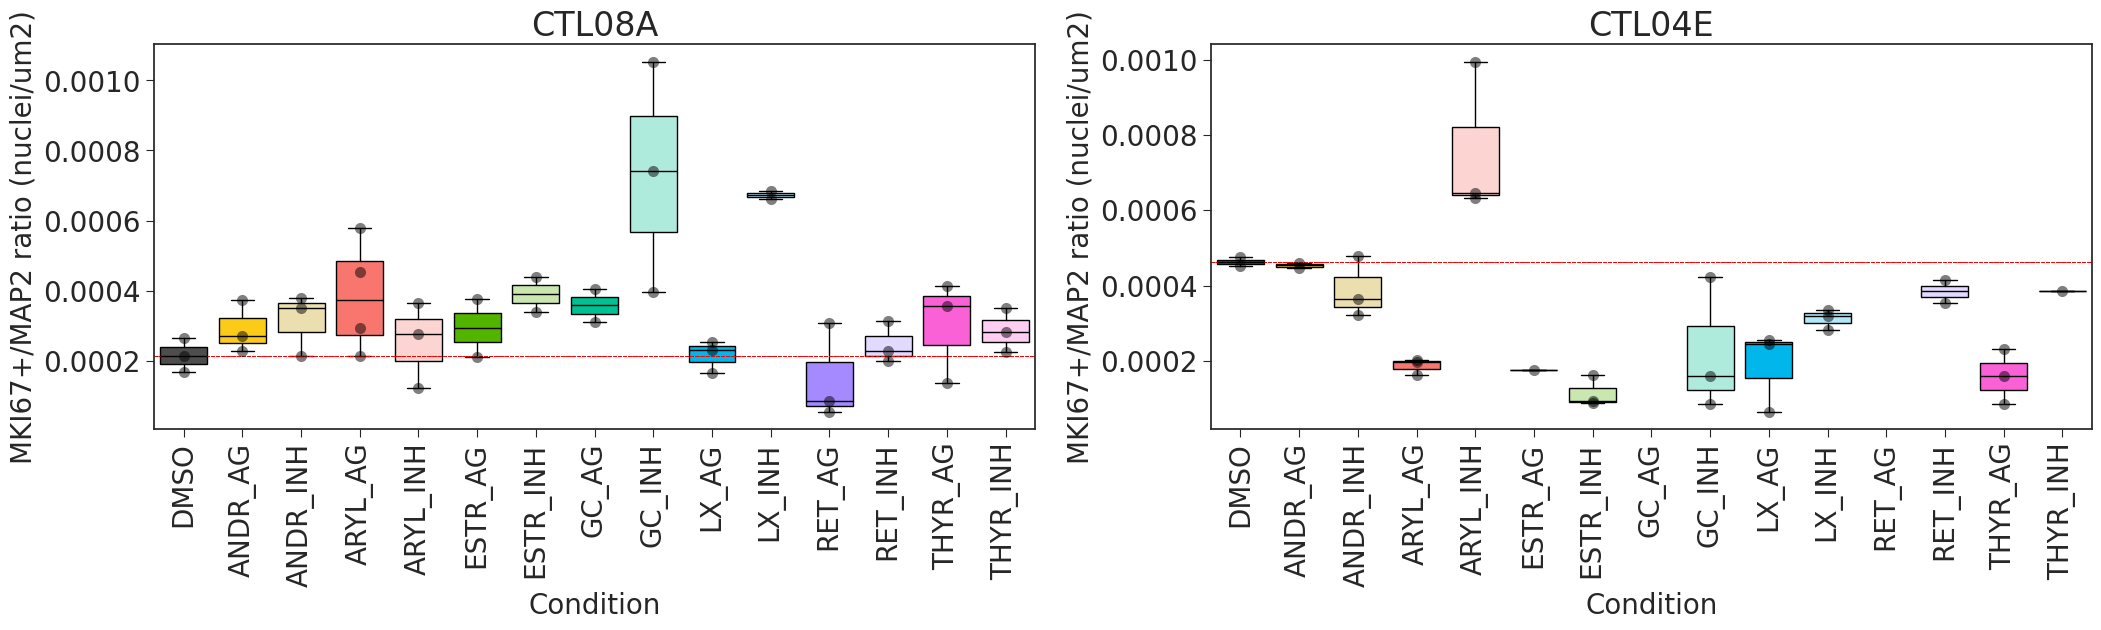

In [460]:
fig, ax = plt.subplots(1, 2, figsize=(25, 5))
for i, cond in enumerate(hormonal_conditions):
    data = df[(df['Line'] == 'CTL08A') & 
                                 (df['Condition'] == cond)]['MKI67+_MAP2_ratio']
    box = ax[0].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
        # Add stripplot for CTL08A (single points per box)

    dmso_median = df[(df['Condition'] == 'DMSO') & 
                                       (df['Line'] == 'CTL08A')]['MKI67+_MAP2_ratio'].median()
    ax[0].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df[(df['Line'] == 'CTL08A')],
    y='MKI67+_MAP2_ratio', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[0], size=8
)

for i, cond in enumerate(hormonal_conditions):
    data = df[(df['Line'] == 'CTL04E') & 
                                 (df['Condition'] == cond)]['MKI67+_MAP2_ratio']
    box = ax[1].boxplot(data, positions=[i], patch_artist=True, widths=.8)
    for patch in box['boxes']:
        patch.set_facecolor(color_palette[cond])
        box['medians'][0].set_color('black')
    dmso_median = df[(df['Condition'] == 'DMSO') & 
                                       (df['Line'] == 'CTL04E')]['MKI67+_MAP2_ratio'].median()
    ax[1].axhline(dmso_median, color='red', linestyle='--', linewidth=.7, alpha=0.7)

sns.stripplot(
    data=df[df['Line'] == 'CTL04E'],
    y='MKI67+_MAP2_ratio', x='Condition', order=hormonal_conditions, color='black', alpha=0.5, jitter=False, ax=ax[1], size=8
)

_ = ax[0].set_xticks(range(len(hormonal_conditions)))
_ = ax[0].set_xticklabels(hormonal_conditions, rotation=90)

_ = ax[1].set_xticks(range(len(hormonal_conditions)))
_ = ax[1].set_xticklabels(hormonal_conditions, rotation=90)

ax[0].set_title('CTL08A')
ax[1].set_title('CTL04E')

ax[0].set_ylabel('MKI67+/MAP2 ratio (nuclei/um2)')
ax[1].set_ylabel('MKI67+/MAP2 ratio (nuclei/um2)')

plt.savefig('../../endpoints_figures/MKI67+_MAP2_ratio_per_condition.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../endpoints_figures/MKI67+_MAP2_ratio_per_condition.png', dpi=300, bbox_inches='tight')